# Model calibration analysis

Personalized medicine applications, such as DiabNet, demands models that output calibrated probability estimates, that are representative of the true likelihood of a prediction. However, most models are not calibrated out of the box but are recalibrated by post-processing model outputs.

In this sense, this Jupyter notebook contains the calibration error of the models, including confidence intervals by Bootstrap resampling and code to recalibrate the models.

## Imports and configuration

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Import required libraries
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.stats as st
import calibration
from astropy.stats import bootstrap
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.model_selection import StratifiedKFold

# Import custom functions
from diabnet.ensemble import Ensemble
from diabnet.analysis.report import DiabNetReport

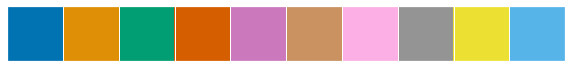

In [3]:
# Configuring color palette
sns.set()
colors = sns.color_palette("colorblind")
sns.palplot(colors)
sns.set_style("whitegrid")
sns.set_style("ticks",{'axes.grid': True,'grid.color': '.95', 'grid.linestyle': '-', 'grid.zorder': 0})

# Save plots to files
SAVE = False

# Verbosity
VERBOSE = False

## Loading ensemble data

In [4]:
# Loading ensemble
ensemble = Ensemble('../results/models/positive/model-positive-21-adamw-lc7-2021-10-05')

In [5]:
# Create DiabNet Report
report = DiabNetReport(ensemble, "positivo_1000_random_0.csv")

NEGATIVE FILE ../data/datasets/visits_sp_unique_test_positivo_1000_random_0_negatives_older60.csv


In [6]:
# Prepare data with labels and predictions
data = pd.DataFrame(report.dataset_test_unique.features)
data.columns = report.feat_names
data['T2D'] = report.dataset_test_unique.labels
data['Pred'] = report.dataset_test_unique.predictions

### Plot 1: Calibration curve of uncalibrated DiabNet classifier

In [7]:
# Get ECE
ece = report.ece(bootnum=10000, interval='HDI')

# Get MCE
mce = report.mce(bootnum=10000, interval='HDI')

# Get Brier Score
brier = report.brier(bootnum=10000, interval='HDI')

if VERBOSE:
    print(ece, mce, brier)

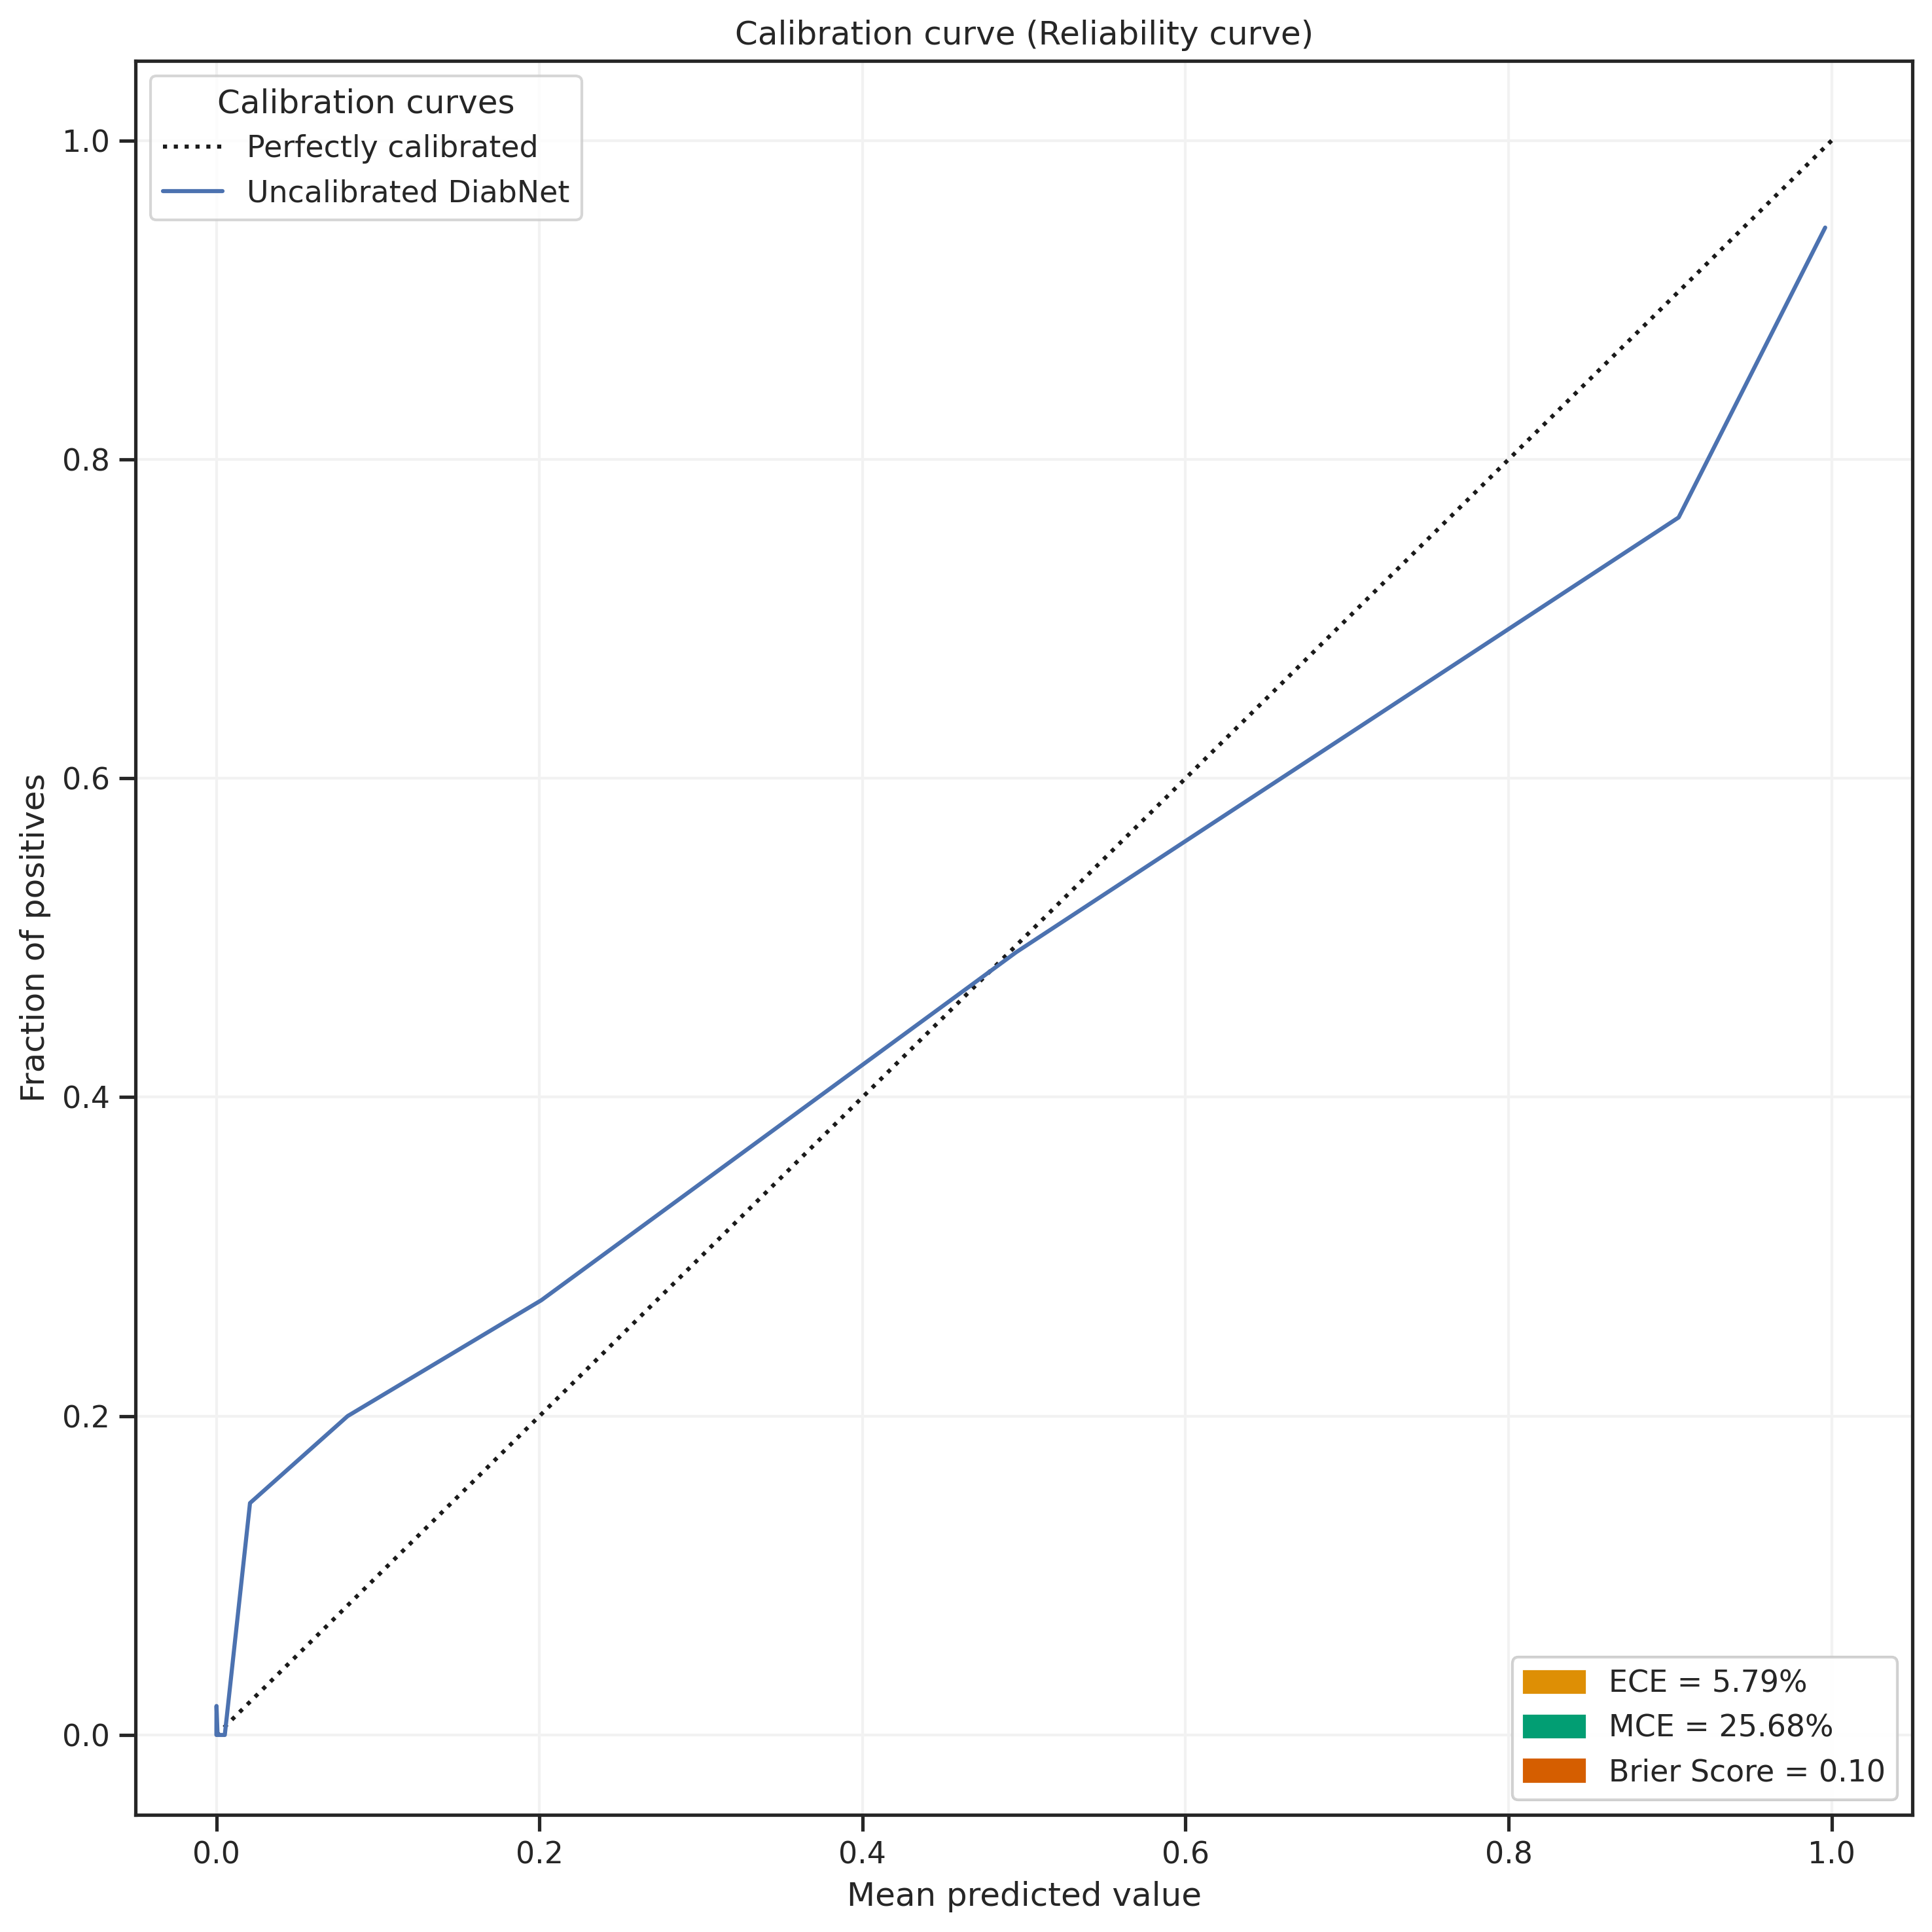

In [8]:
# Create figure
plt.figure(figsize=(10, 10), dpi=300)

# Create subplot
ax = plt.subplot(111)

# Plot calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(
    data['T2D'], 
    data['Pred'], 
    n_bins=10, 
    strategy='quantile'
)

# Plot perfectly calibrated curve
ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

# Plot DiabNet curve
ax.plot(mean_predicted_value, fraction_of_positives, label="Uncalibrated DiabNet")

# ECE and MCE legend
ECE = mpatches.Patch(color=colors[1], label='ECE = {:.2f}%'.format(ece['value']*100))
MCE = mpatches.Patch(color=colors[2], label='MCE = {:.2f}%'.format(mce['value']*100))
BRIER = mpatches.Patch(color=colors[3], label='Brier Score = {:.2f}'.format(brier['value']))

# Configuring plot
ax.set_title('Calibration curve (Reliability curve)')
ax.set_ylabel('Fraction of positives')
ax.set_xlabel('Mean predicted value')

# Configure legend
legend1 = plt.legend(
    title='Calibration curves',
    loc="upper left",
)

legend2 = plt.legend(
    loc="lower right",
    handles=[ECE, MCE, BRIER]
)
ax.add_artist(legend1)
ax.add_artist(legend2)

# Display plot
plt.tight_layout()
plt.show()

# Save figure to file
if SAVE:
    if not os.path.exists("./images"):
        os.makedirs("./images")
    plt.savefig("./images/notebook3-plot1.svg", dpi=300)

## Calibrating DiabNet (Platt, PlattBinning, Histogram)

In [9]:
# Get calibration error of uncalibrated model
ce_uncalibrated_diabnet = calibration.get_calibration_error(data['Pred'], data['T2D'])
print(f"Calibration Error: {ce_uncalibrated_diabnet * 100:.2f}%")

# Get ECE
ece = calibration.get_ece(data['Pred'], data['T2D'])
print(f"ECE: {ece * 100:.2f}%")

Calibration Error: 5.97%
ECE: 5.85%


The calibration methods allow us to better calibrate the probabilities of the DiabNet model, or even to add support for probability prediction.

Importantly, the samples that are used to fit the calibrator **should not be** the same samples used to fit the classifier, as this would introduce bias. This means that the classifier performance would be better on its training data than for novel data. Thus, using the classifier output of training data to fit the calibrator would yield in a biased calibrator that maps to probabilities closer to 0 and 1 than it should.

**Based on this, we used the test data to fit our DiabNet calibrator.**

In [10]:
# Load training data

In [11]:
# Create pandas DataFrame with:
# - labels
# - uncalibrated predictions
# - platt-calibrated predictions
# - platt-binning calibrated predictions
# - histrogram predictions
calibrated_data = pd.DataFrame({
    'Labels': data['T2D'].to_numpy(), 
    'Uncalibrated Predictions': data['Pred'].to_numpy(),
    'Platt-calibrated Predictions': np.empty(550),
    'Platt-binning-calibrated Predictions': np.empty(550),
    'Histogram-calibrated Predictions': np.empty(550),
})

if VERBOSE:
    display(calibrated_data)

### Platt Calibrator

In [12]:
# Platt-calibrator

# Use Platt binning to train a recalibrator.
calibrator = calibration.PlattCalibrator(250, num_bins=10)
calibrator.train_calibration(
    calibrated_data['Uncalibrated Predictions'][0:250], 
    calibrated_data['Labels'][0:250]
)

# Measure the calibration error of recalibrated model.
calibrated_data['Platt-calibrated Predictions'] = calibrator.calibrate(
    calibrated_data['Uncalibrated Predictions']
)

# Get calibration error of uncalibrated model
ce_platt_calibrated_diabnet = calibration.get_calibration_error(
    calibrated_data['Platt-calibrated Predictions'][250:], 
    calibrated_data['Labels'][250:]
)
print(f"Calibration Error: {ce_platt_calibrated_diabnet * 100:.2f}%")

# Get ECE
ece = calibration.get_ece(
    calibrated_data['Platt-calibrated Predictions'][250:], 
    calibrated_data['Labels'][250:]
)
print(f"ECE: {ece * 100:.2f}%")

Calibration Error: 0.00%
ECE: 6.87%


#### Plot 2: Calibration curve of Platt calibrated DiabNet

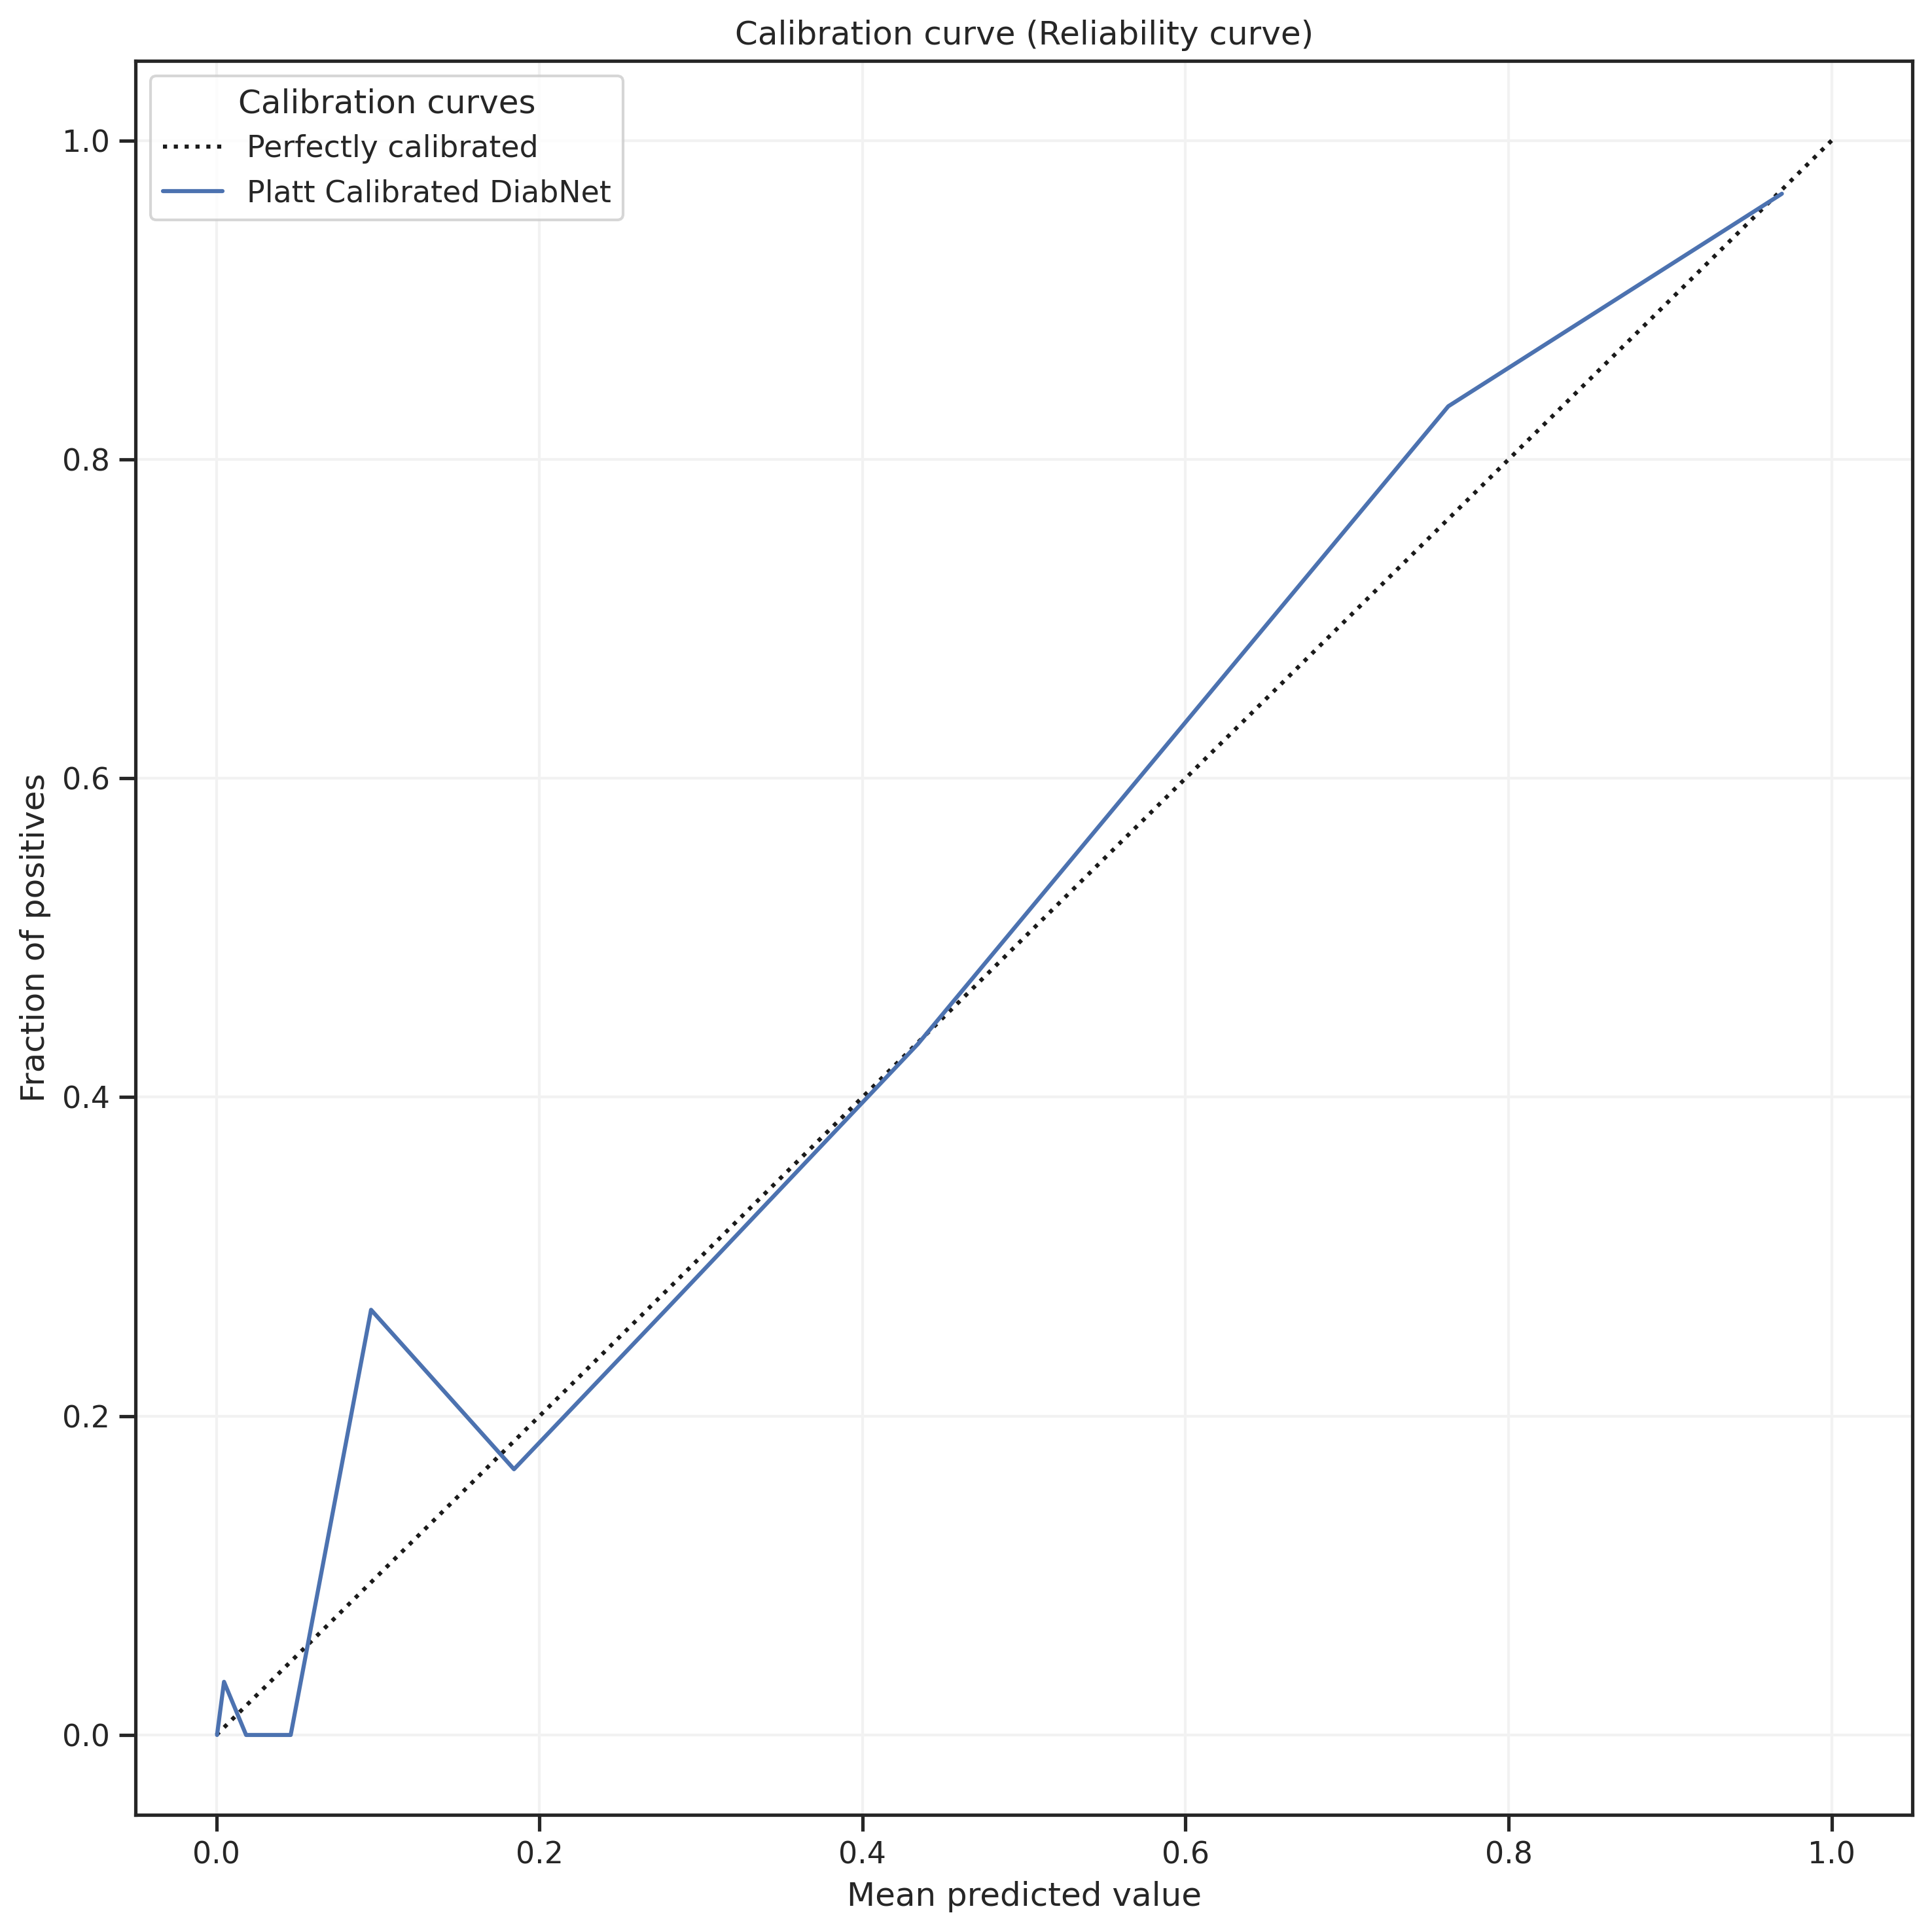

In [13]:
# Create figure
plt.figure(figsize=(10, 10), dpi=300)

# Create subplot
ax = plt.subplot(111)

# Plot calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(
    calibrated_data['Labels'][250:], 
    calibrated_data['Platt-calibrated Predictions'][250:], 
    n_bins=10, 
    strategy='quantile'
)

# Plot perfectly calibrated curve
ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

# Plot DiabNet curve
ax.plot(mean_predicted_value, fraction_of_positives, label="Platt Calibrated DiabNet")

# Configuring plot
ax.set_title('Calibration curve (Reliability curve)')
ax.set_ylabel('Fraction of positives')
ax.set_xlabel('Mean predicted value')

# Configure legend
ax.legend(
    title='Calibration curves',
    loc="upper left",
)

# Display plot
plt.tight_layout()
plt.show()

# Save figure to file
if SAVE:
    if not os.path.exists("./images"):
        os.makedirs("./images")
    plt.savefig("./images/notebook3-plot2.svg", dpi=300)

### Platt-binning Calibrator

In [14]:
# Platt-binning calibrator

# Use Platt binning to train a recalibrator.
calibrator = calibration.PlattBinnerCalibrator(250, num_bins=10)
calibrator.train_calibration(
    calibrated_data['Uncalibrated Predictions'][0:250], 
    calibrated_data['Labels'][0:250]
)

# Measure the calibration error of recalibrated model.
calibrated_data['Platt-binning-calibrated Predictions'] = calibrator.calibrate(
    calibrated_data['Uncalibrated Predictions']
)

# Get calibration error of uncalibrated model
ce_platt_binning_calibrated_diabnet = calibration.get_calibration_error(
    calibrated_data['Platt-binning-calibrated Predictions'][250:], 
    calibrated_data['Labels'][250:]
)
print(f"Calibration Error: {ce_platt_binning_calibrated_diabnet * 100:.2f}%")

# Get ECE
ece = calibration.get_ece(
    calibrated_data['Platt-binning-calibrated Predictions'][250:], 
    calibrated_data['Labels'][250:]
)
print(f"ECE: {ece * 100:.2f}%")

Calibration Error: 0.00%
ECE: 2.80%


#### Plot 3: Calibration curve of Platt-binning calibrated DiabNet

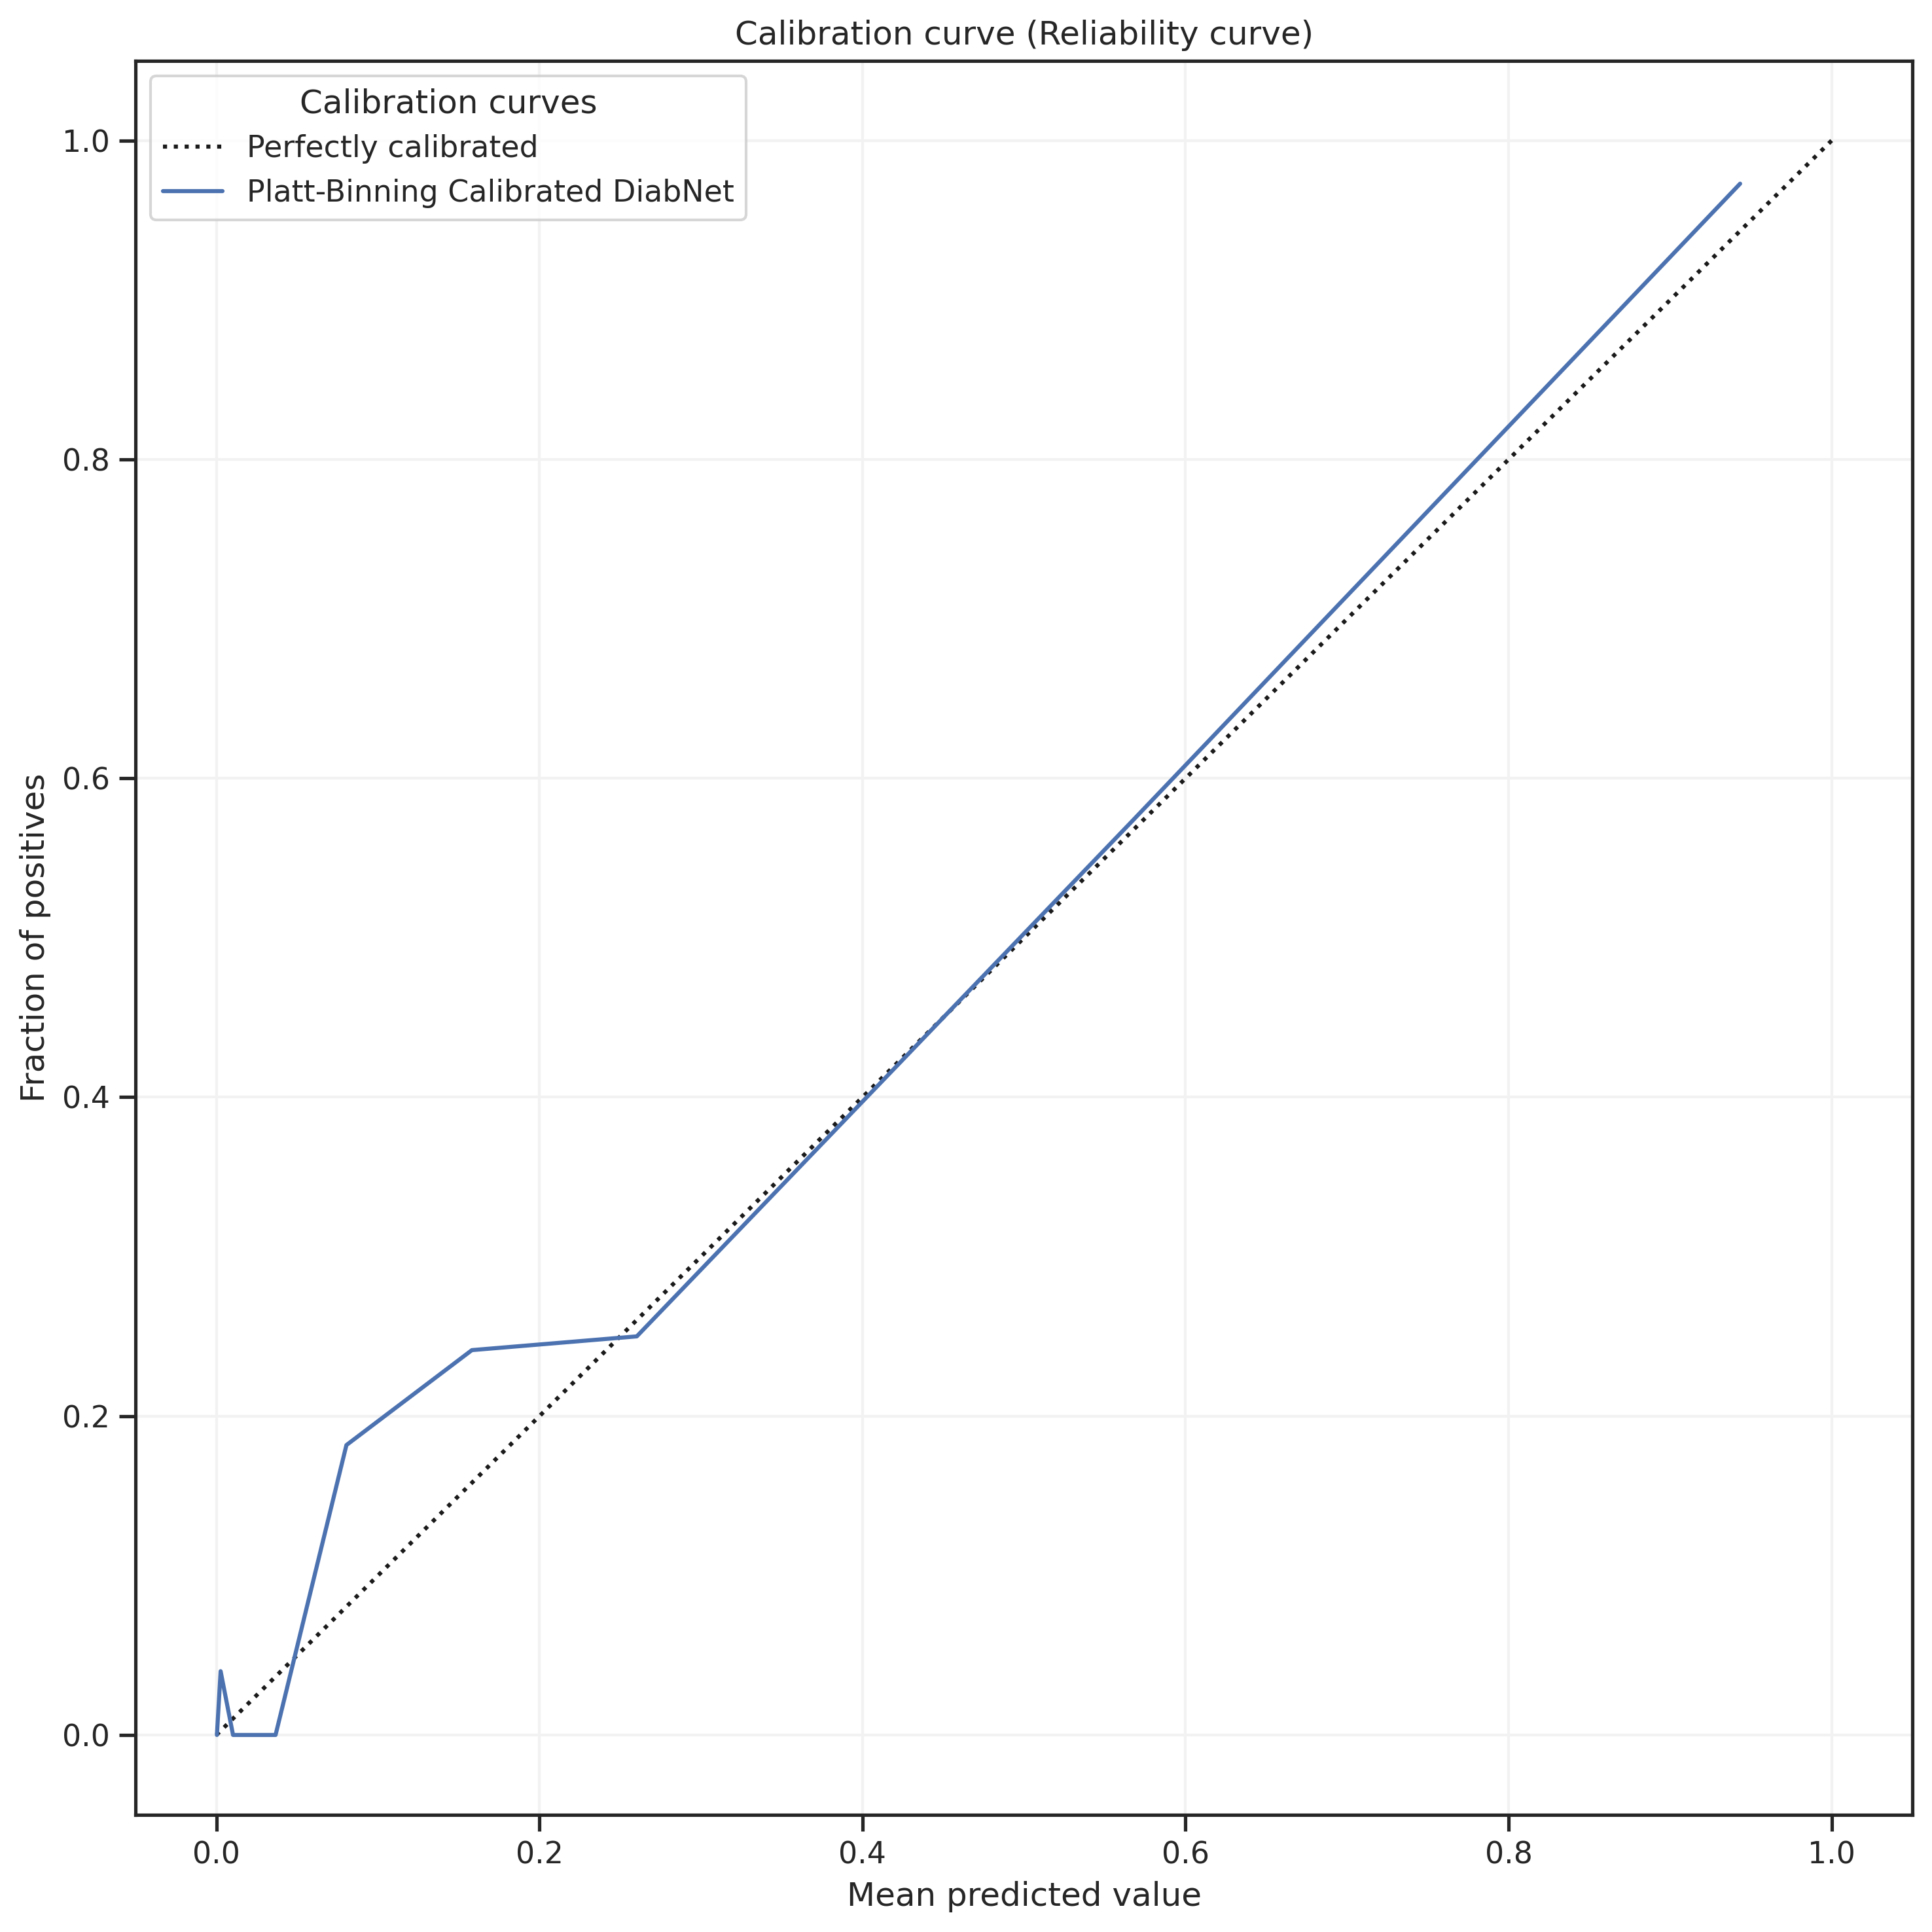

In [15]:
# Create figure
plt.figure(figsize=(10, 10), dpi=300)

# Create subplot
ax = plt.subplot(111)

# Plot calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(
    calibrated_data['Labels'][250:], 
    calibrated_data['Platt-binning-calibrated Predictions'][250:], 
    n_bins=10, 
    strategy='quantile'
)

# Plot perfectly calibrated curve
ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

# Plot DiabNet curve
ax.plot(mean_predicted_value, fraction_of_positives, label="Platt-Binning Calibrated DiabNet")

# Configuring plot
ax.set_title('Calibration curve (Reliability curve)')
ax.set_ylabel('Fraction of positives')
ax.set_xlabel('Mean predicted value')

# Configure legend
ax.legend(
    title='Calibration curves',
    loc="upper left",
)

# Display plot
plt.tight_layout()
plt.show()

# Save figure to file
if SAVE:
    if not os.path.exists("./images"):
        os.makedirs("./images")
    plt.savefig("./images/notebook3-plot3.svg", dpi=300)

### Histogram Calibrator

In [16]:
# Histogram calibrator

# Use Platt binning to train a recalibrator.
calibrator = calibration.HistogramCalibrator(250, num_bins=10)
calibrator.train_calibration(
    calibrated_data['Uncalibrated Predictions'][0:250], 
    calibrated_data['Labels'][0:250]
)

# Measure the calibration error of recalibrated model.
calibrated_data['Histogram-calibrated Predictions'] = calibrator.calibrate(
    calibrated_data['Uncalibrated Predictions']
)

# Get calibration error of uncalibrated model
ce_histogram_calibrated_diabnet = calibration.get_calibration_error(
    calibrated_data['Histogram-calibrated Predictions'][250:], 
    calibrated_data['Labels'][250:]
)
print(f"Calibration Error: {ce_histogram_calibrated_diabnet * 100:.2f}%")

# Get ECE
ece = calibration.get_ece(
    calibrated_data['Histogram-calibrated Predictions'][250:], 
    calibrated_data['Labels'][250:]
)
print(f"ECE: {ece * 100:.2f}%")

Calibration Error: 5.18%
ECE: 5.92%


#### Plot 4: Calibration curve of Histogram calibrated DiabNet

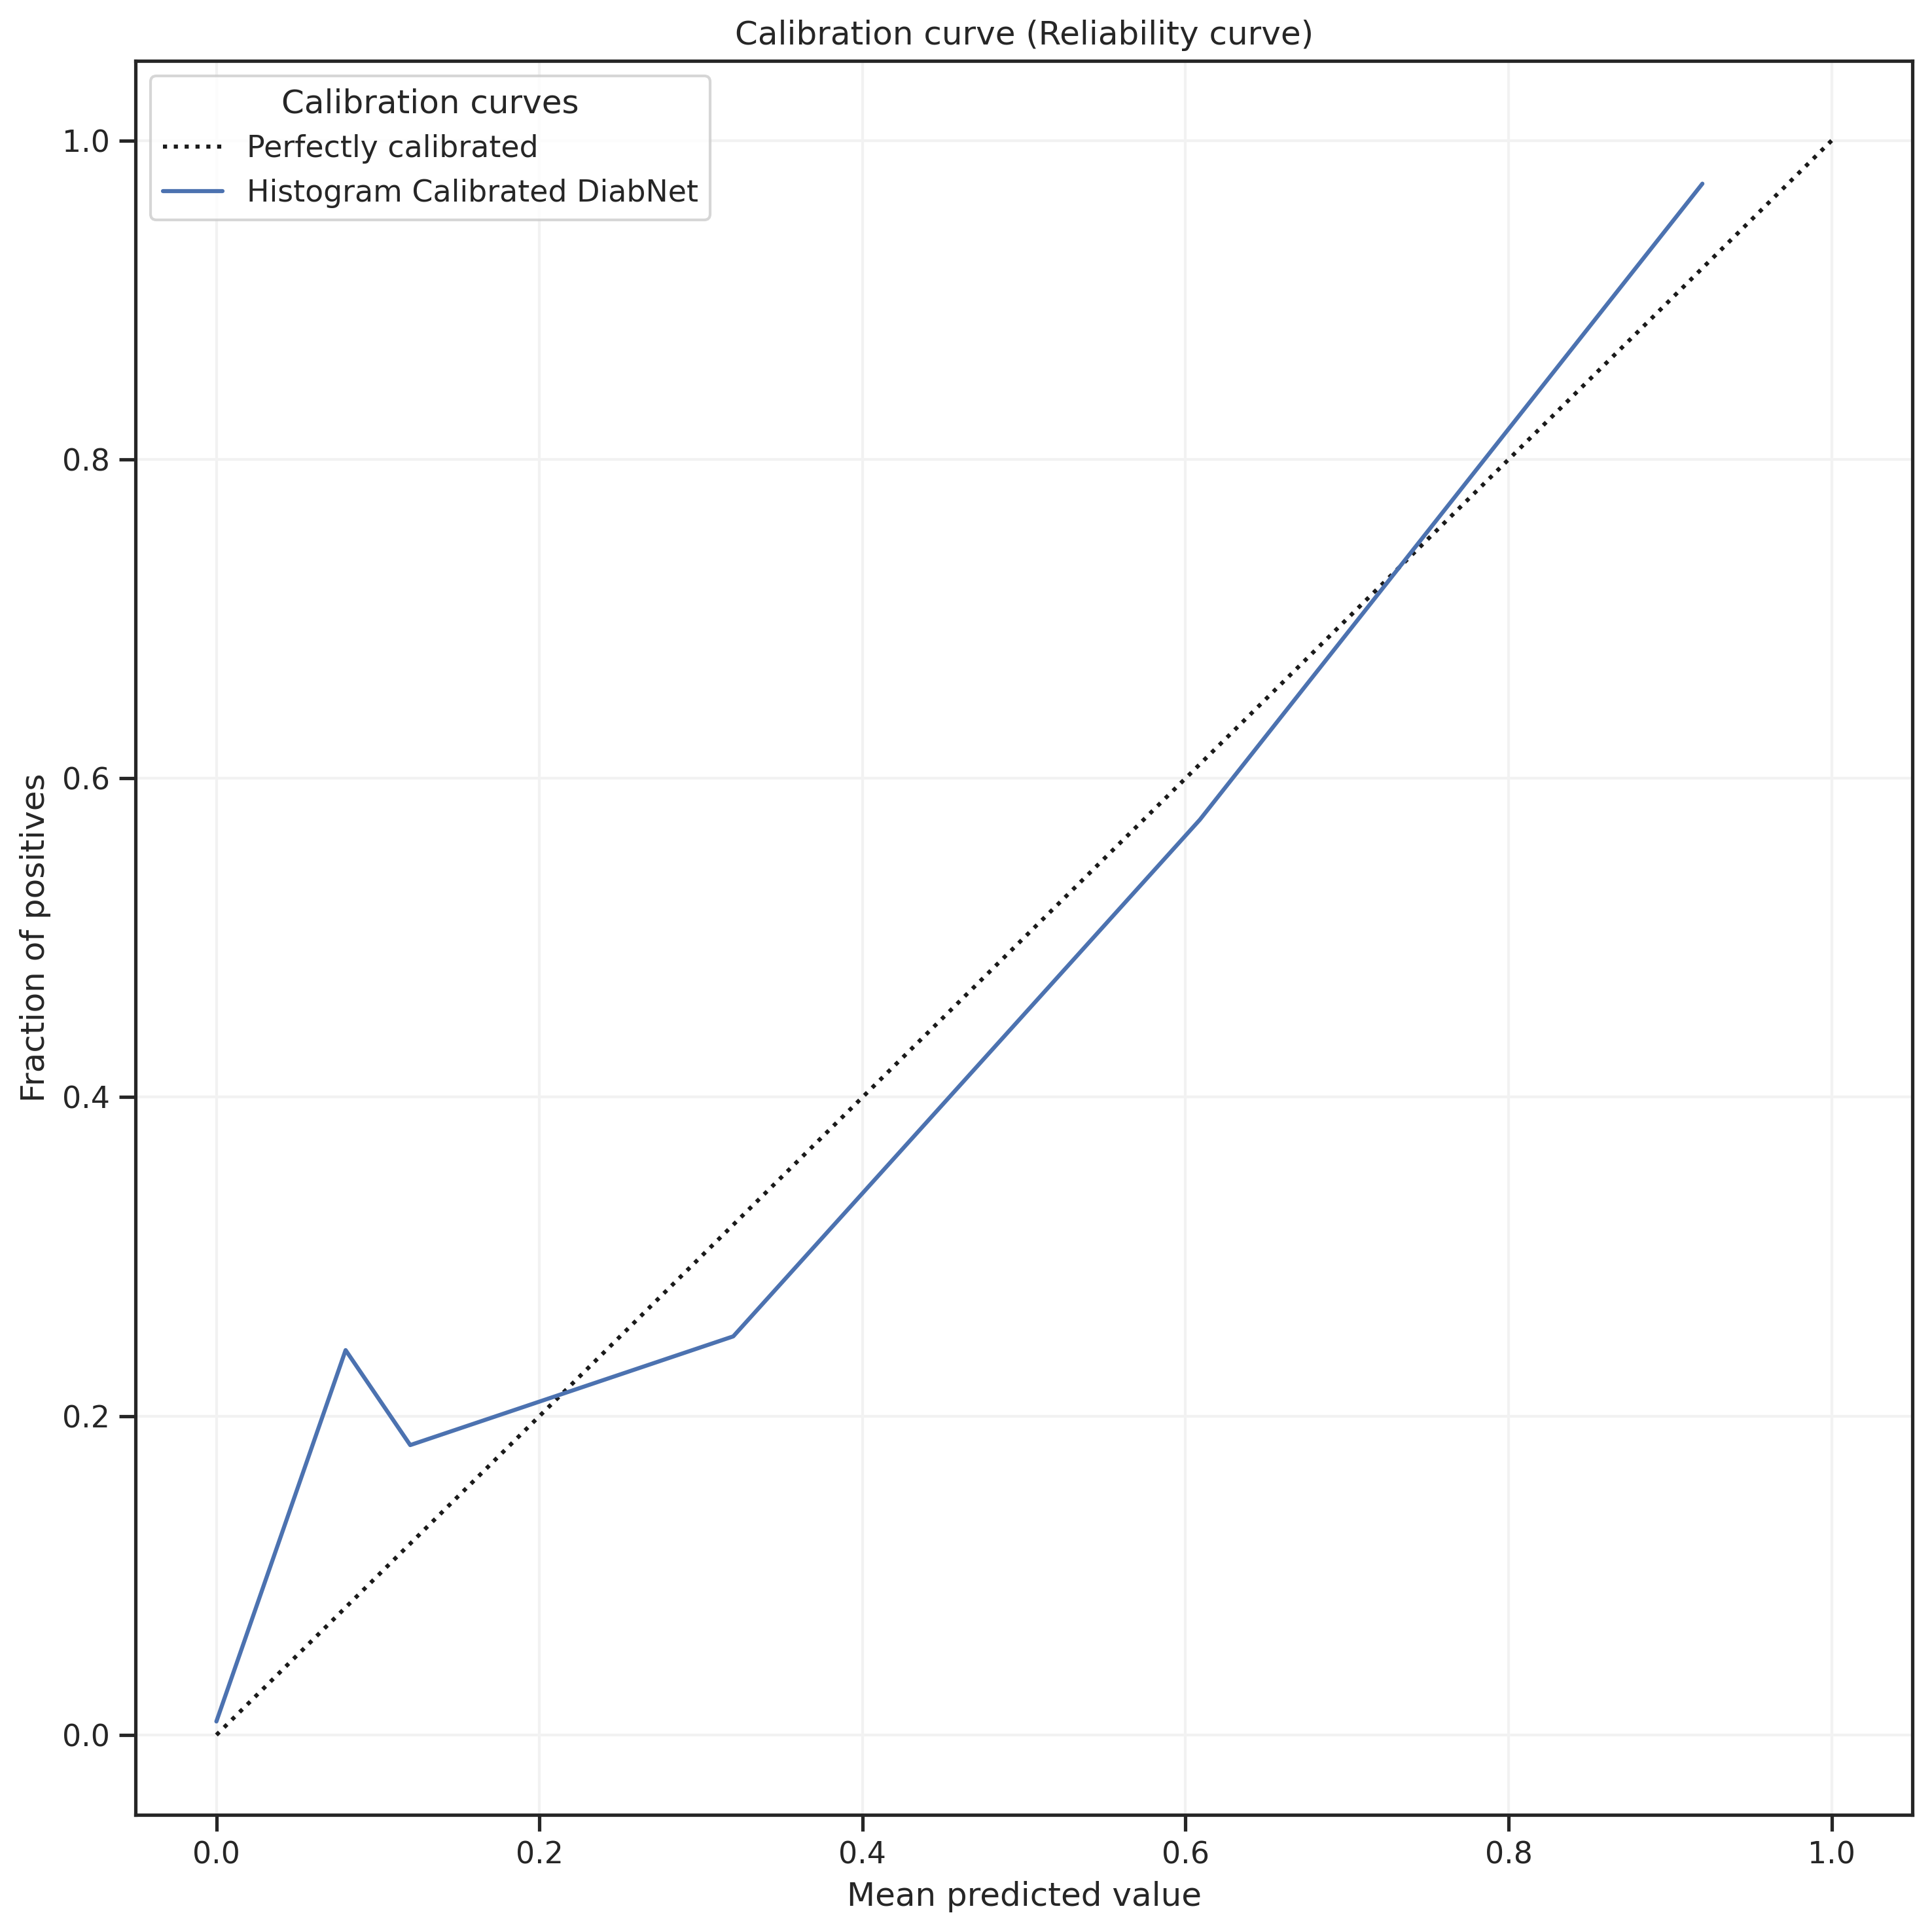

In [17]:
# Create figure
plt.figure(figsize=(10, 10), dpi=300)

# Create subplot
ax = plt.subplot(111)

# Plot calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(
    calibrated_data['Labels'][250:], 
    calibrated_data['Histogram-calibrated Predictions'][250:], 
    n_bins=10, 
    strategy='quantile'
)

# Plot perfectly calibrated curve
ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

# Plot DiabNet curve
ax.plot(mean_predicted_value, fraction_of_positives, label="Histogram Calibrated DiabNet")

# Configuring plot
ax.set_title('Calibration curve (Reliability curve)')
ax.set_ylabel('Fraction of positives')
ax.set_xlabel('Mean predicted value')

# Configure legend
ax.legend(
    title='Calibration curves',
    loc="upper left",
)

# Display plot
plt.tight_layout()
plt.show()

# Save figure to file
if SAVE:
    if not os.path.exists("./images"):
        os.makedirs("./images")
    plt.savefig("./images/notebook3-plot4.svg", dpi=300)

#### Plot 5: Calibration curves

In [18]:
# Display calibrated data
display(calibrated_data)

,Labels,Uncalibrated Predictions,Platt-calibrated Predictions,Platt-binning-calibrated Predictions,Histogram-calibrated Predictions
0,1,9.986132e-01,0.966526,0.943349,0.92
1,0,6.849491e-06,0.001214,0.002613,0.00
2,1,1.570610e-01,0.241828,0.260270,0.32
3,0,2.554847e-06,0.000709,0.000316,0.00
4,0,1.617719e-07,0.000157,0.000316,0.00
...,...,...,...,...,...
545,0,1.192035e-06,0.000468,0.000316,0.00
546,0,3.731071e-01,0.375389,0.452991,0.56
547,0,9.517392e-07,0.000414,0.000316,0.00
548,0,1.115489e-02,0.064617,0.080497,0.12


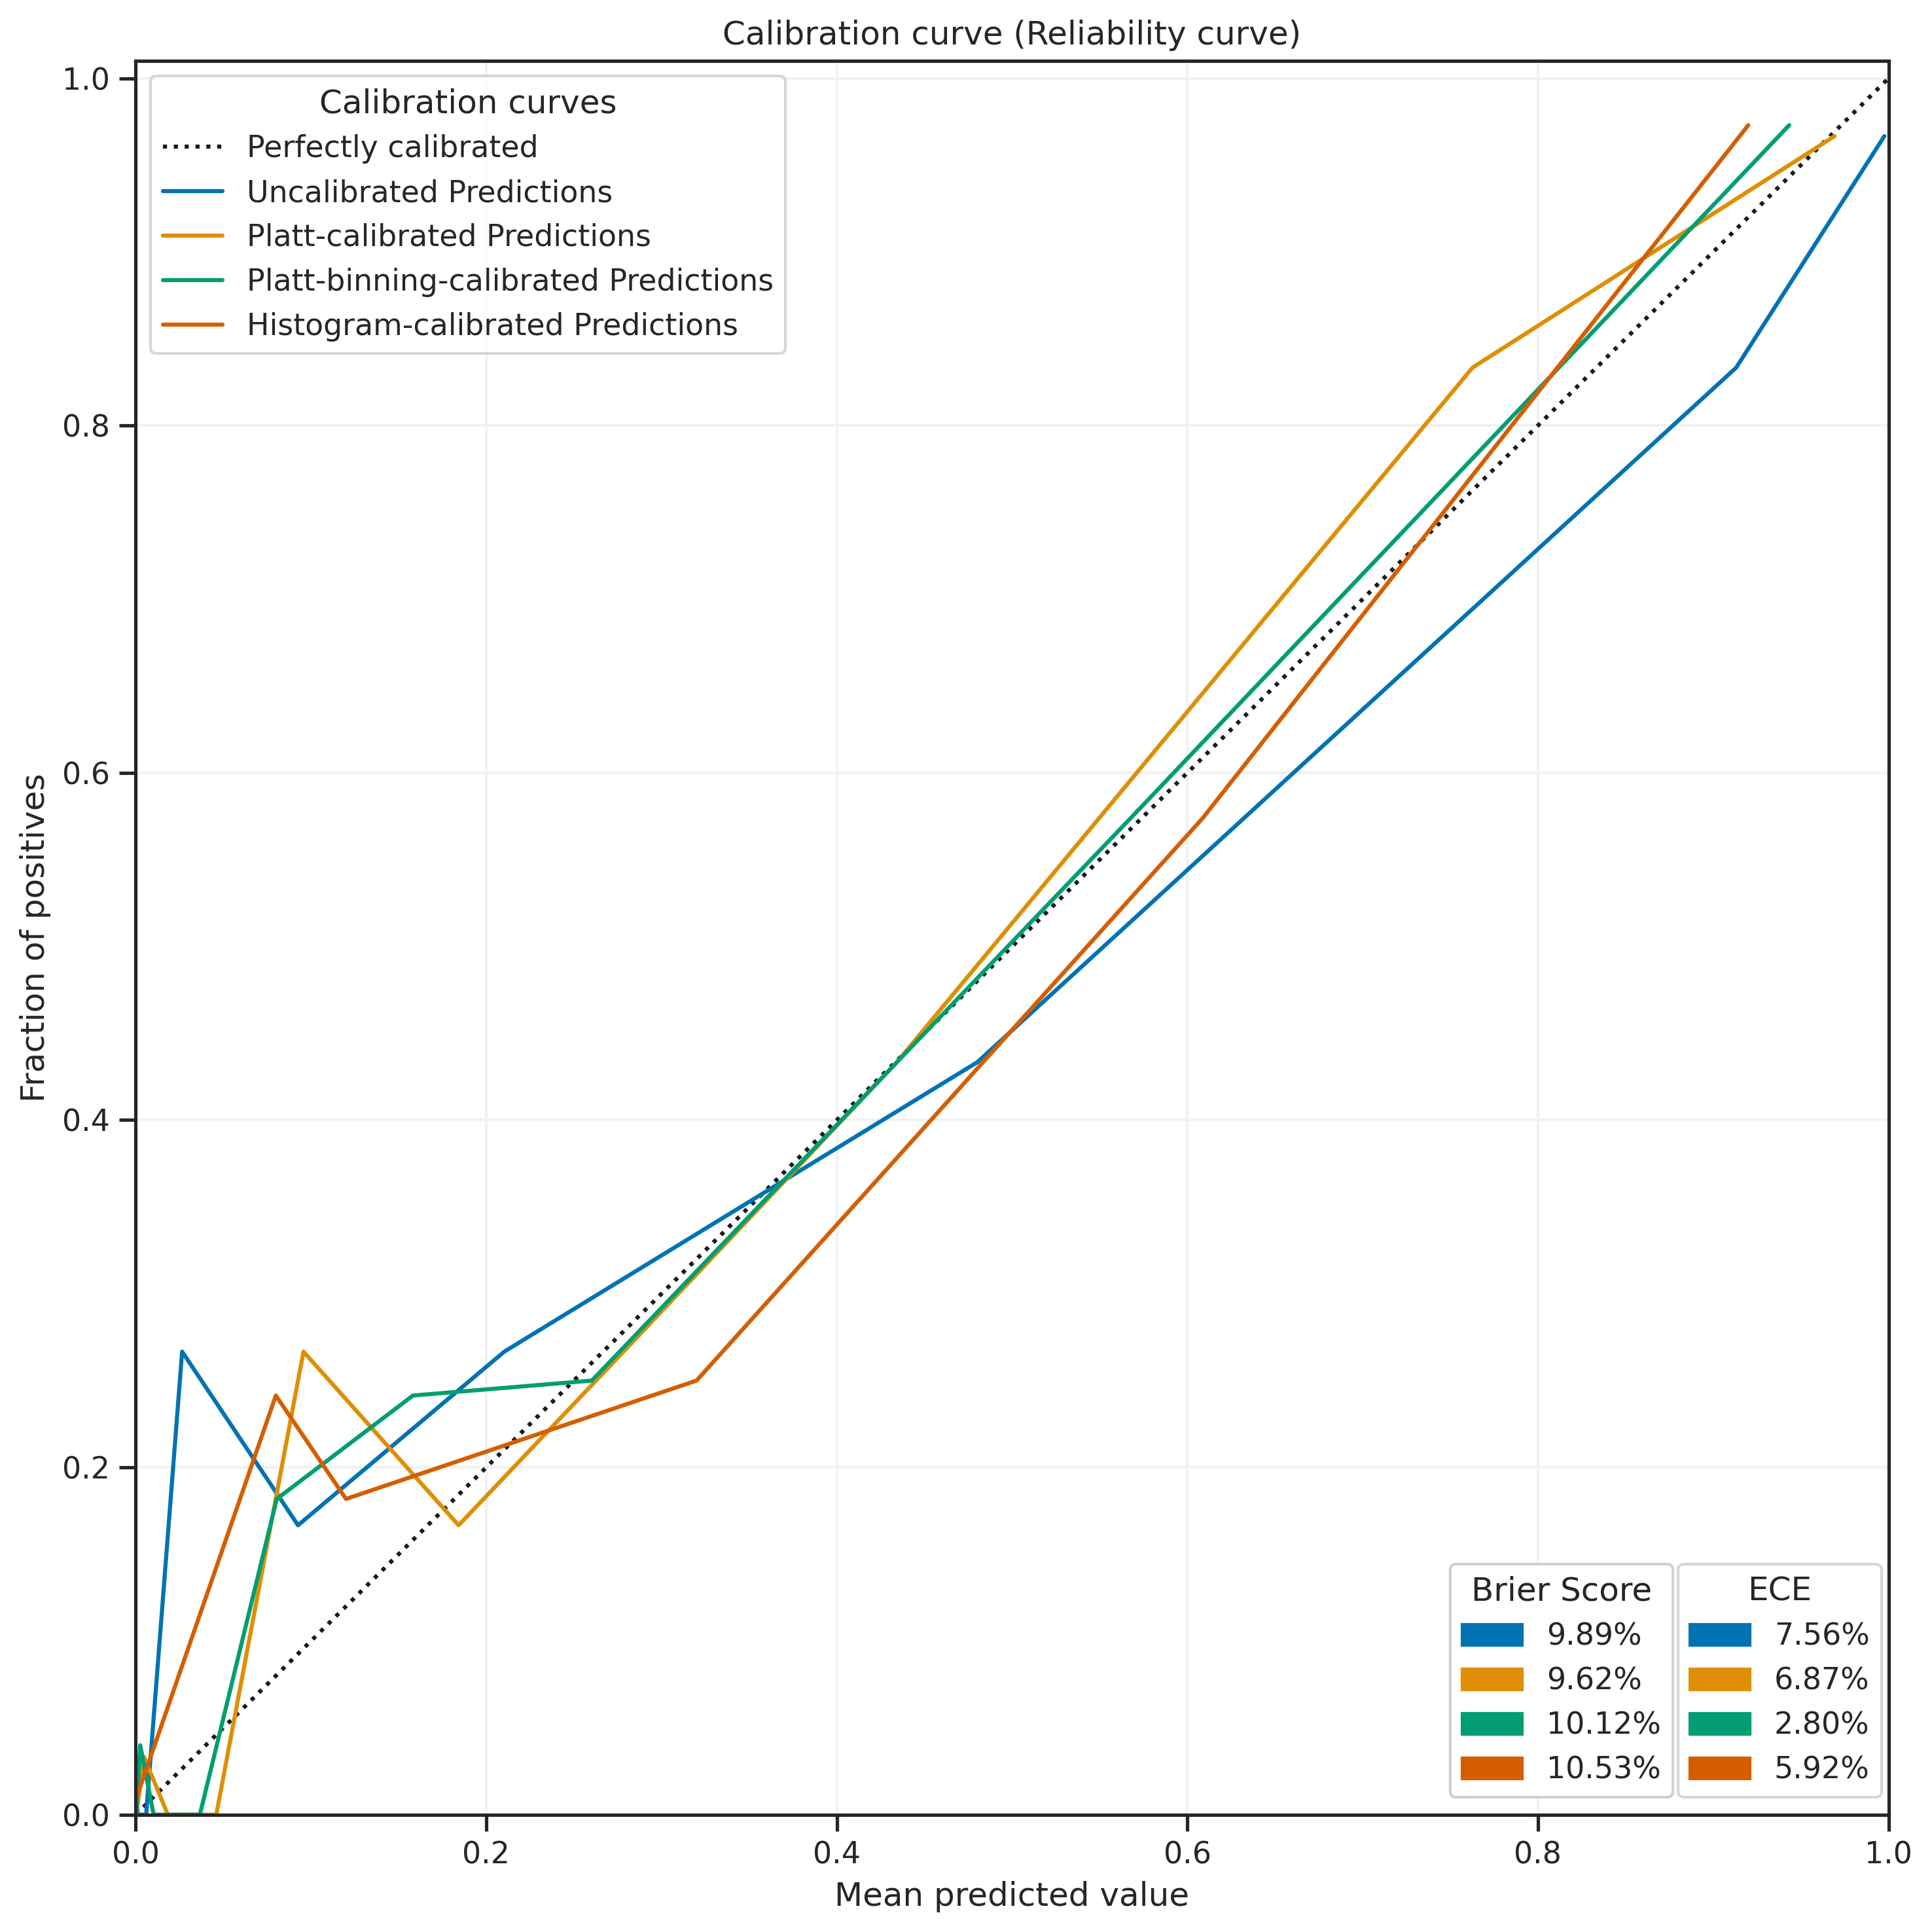

In [19]:
# Create figure
plt.figure(figsize=(10, 10), dpi=300)

# Create subplot
ax = plt.subplot(111)

# Plot perfectly calibrated curve
ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

# Iterate in calibrators
for i, calibrator in enumerate(calibrated_data.columns[1:5]):
    
    # Plot calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        calibrated_data['Labels'][250:], 
        calibrated_data[calibrator][250:], 
        n_bins=10, 
        strategy='quantile'
    )

    # Plot DiabNet curve
    ax.plot(mean_predicted_value, fraction_of_positives, label=calibrator, color=colors[i])

# Get ECE for calibrator
ECE = []
for i, calibrator in enumerate(calibrated_data.columns[1:5]):
    # Calculate ECE
    ece = calibration.get_ece(
        calibrated_data[calibrator][250:], 
        calibrated_data['Labels'][250:]
    )
    ECE.append(mpatches.Patch(color=colors[i], label='{:.2f}%'.format(ece*100)))

# Get Brier Score for calibrator
Brier = []
for i, calibrator in enumerate(calibrated_data.columns[1:5]):
    # Calculate ECE
    bs = brier_score_loss(calibrated_data['Labels'][250:], calibrated_data[calibrator][250:])
    Brier.append(mpatches.Patch(color=colors[i], label='{:.2f}%'.format(bs*100)))    

# Configuring plot
ax.set_title('Calibration curve (Reliability curve)')
ax.set_ylabel('Fraction of positives')
ax.set_xlabel('Mean predicted value')
ax.set_ylim(0.0, 1.01)
ax.set_xlim(0.0, 1.00)

# Configure legend
legend1 = plt.legend(
    title='Calibration curves',
    loc="upper left",
)

legend2 = plt.legend(
    title="ECE",
    loc=(0.88, .01),
    handles=ECE
)

legend3 = plt.legend(
    title="Brier Score",
    loc=(0.75, .01),
    handles=Brier
)
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.add_artist(legend3)

# Display plot
plt.tight_layout()
plt.show()

# Save figure to file
if SAVE:
    if not os.path.exists("./images"):
        os.makedirs("./images")
    plt.savefig("./images/notebook3-plot5.svg", dpi=300)

## Calibrator cross-validation (10-fold)

In [20]:
# Shuffle and split test dataset in 10 groups
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

In [21]:
# Create empty list for calibrators
calibrators = []

# Train Platt-binning calibrator
for i, (train, _) in enumerate(kf.split(calibrated_data['Uncalibrated Predictions'], calibrated_data['Labels'])):
    # Create Platt-Binning Calibrator
    calibrators.append(calibration.PlattBinnerCalibrator(55, num_bins=10))
    
    # Train calibrator
    calibrators[i].train_calibration(
        calibrated_data['Uncalibrated Predictions'][train], 
        calibrated_data['Labels'][train]
    )

In [22]:
# Create empty list for predictions, ce and ece
predictions, ce, ece = [], [], []

# Get data for calibrator i of 10-fold cross-validation
for i, (_, test) in enumerate(kf.split(calibrated_data['Uncalibrated Predictions'], calibrated_data['Labels'])):
    # Get predictions 
    predictions.append(
        calibrators[i].calibrate(
            calibrated_data['Uncalibrated Predictions'][test]
        )
    )

    # Get CE
    ce.append(
        calibration.get_calibration_error(
            calibrated_data['Platt-binning-calibrated Predictions'][test], 
            calibrated_data['Labels'][test]
        )
    )
    
    # Get ECE
    ece.append(
        calibration.get_ece(
            calibrated_data['Platt-binning-calibrated Predictions'][test], 
            calibrated_data['Labels'][test]
        )
    )

#### Plot 6: Mean cross-validation calibration curve

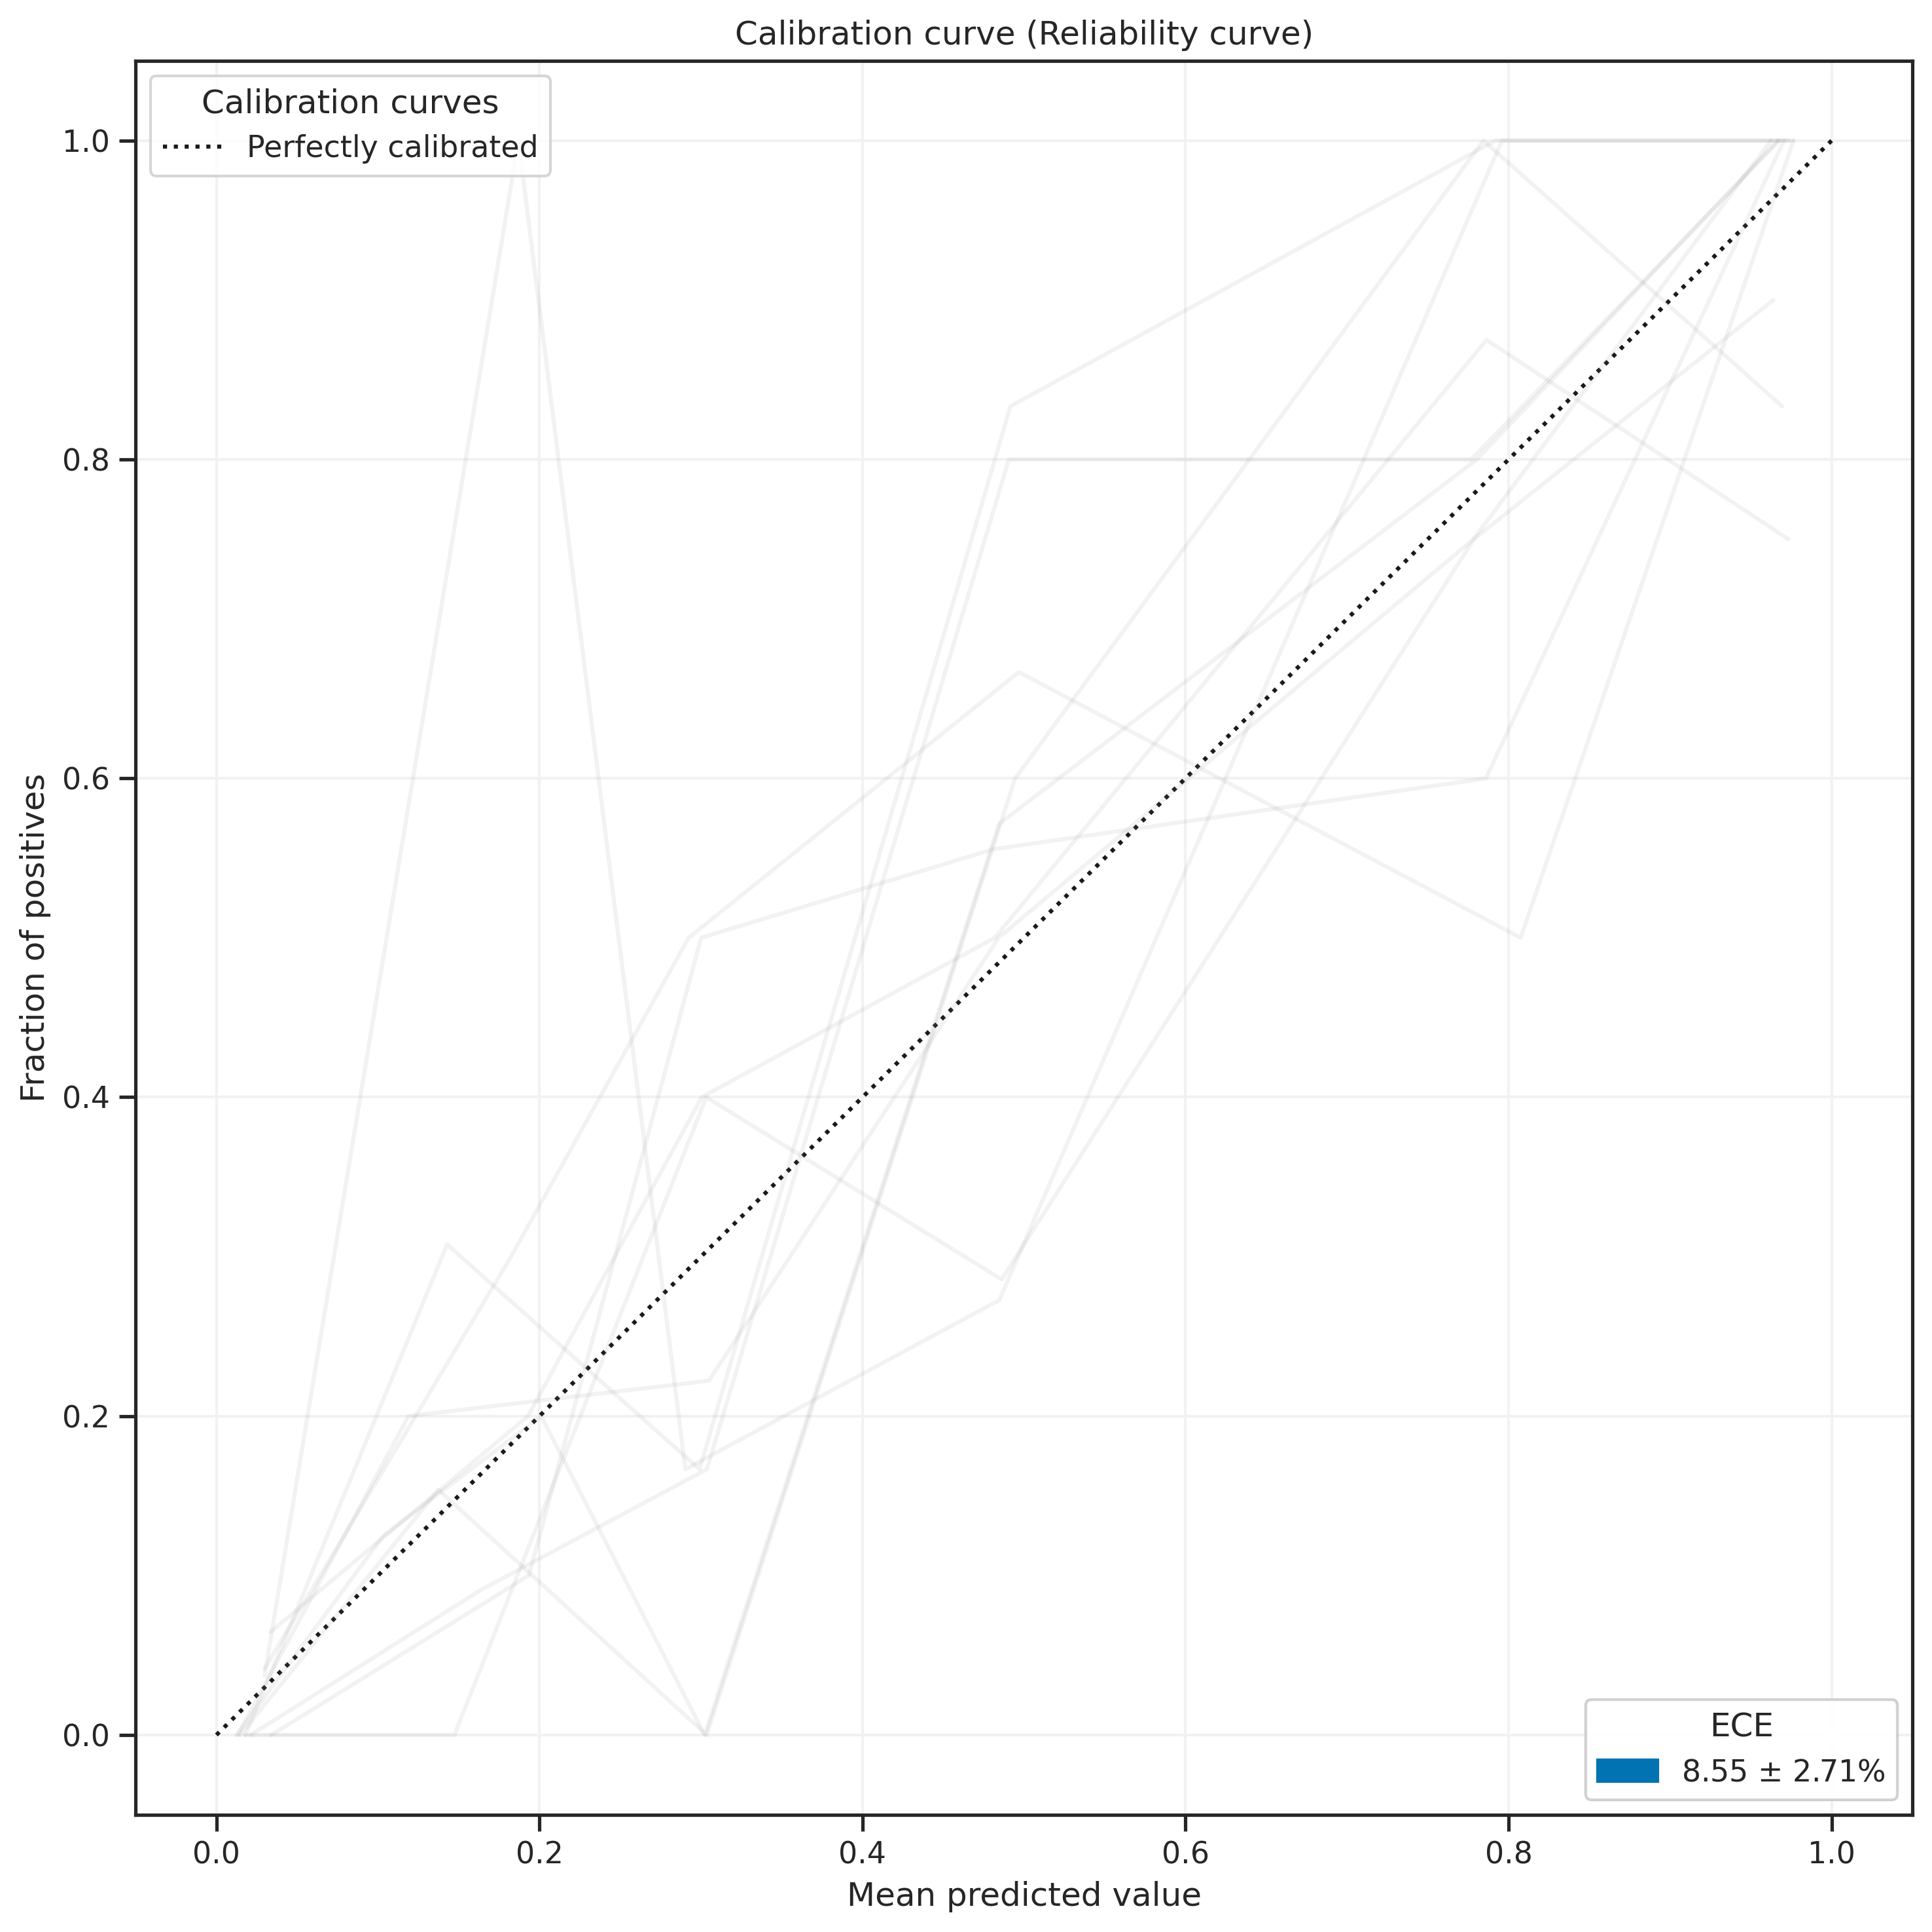

In [23]:
# Create figure
plt.figure(figsize=(10, 10), dpi=300)

# Create subplot
ax = plt.subplot(111)

# Plot perfectly calibrated curve
ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

# Create empty list
fraction_of_positives, mean_predicted_value = [None] * 10, [None] * 10

# Iterate in calibrators
for i, (_, test) in enumerate(kf.split(calibrated_data['Uncalibrated Predictions'], calibrated_data['Labels'])):
    
    # Plot calibration curve
    fraction_of_positives[i], mean_predicted_value[i] = calibration_curve(
        calibrated_data['Labels'][test], 
        predictions[i], 
        n_bins=10, 
        strategy='uniform'
    )

# Plot DiabNet curve
# BUG broadcast não funciona com lista de vetores de tamanhos diferentes
# x = np.mean(mean_predicted_value, axis=0) 
# y = np.mean(fraction_of_positives, axis=0)
# y_std = np.std(fraction_of_positives, axis=0)

# ax.plot(x, y, color=colors[0], label='Average calibration curve')
# ax.fill_between(x, y - y_std, y + y_std, alpha=0.2, linewidth=0.0, facecolor=colors[0], label='Standard deviation')

# Iterate in calibrators
for i, (_, test) in enumerate(kf.split(calibrated_data['Uncalibrated Predictions'], calibrated_data['Labels'])):
    # Plot calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        calibrated_data['Labels'][test], 
        predictions[i], 
        n_bins=10, 
        strategy='uniform'
    )

    # Plot DiabNet curve
    ax.plot(mean_predicted_value, fraction_of_positives, color='gray', alpha=0.1)


# Configuring plot
ax.set_title('Calibration curve (Reliability curve)')
ax.set_ylabel('Fraction of positives')
ax.set_xlabel('Mean predicted value')

# Configure legend
legend1 = plt.legend(
    title='Calibration curves',
    loc="upper left",
)

legend2 = plt.legend(
    title="ECE",
    loc="lower right",
    handles=[
        mpatches.Patch(
            color=colors[0], 
            label=r"{:.2f} $\pm$ {:.2f}%".format(np.mean(ece) * 100, np.std(ece) * 100)
        )
    ]
)

ax.add_artist(legend1)
ax.add_artist(legend2)

# Display plot
plt.tight_layout()
plt.show()

# # Save figure to file
# if SAVE:
#     if not os.path.exists("./images"):
#         os.makedirs("./images")
#     plt.savefig("./images/notebook3-plot6.svg", dpi=300)

## Perform calibrator training with complete test dataset and validate with training dataset

In [24]:
# Platt-binning-calibrator

# Use Platt binning to train a recalibrator.
calibrator = calibration.PlattBinnerCalibrator(550, num_bins=10)
calibrator.train_calibration(
    calibrated_data['Uncalibrated Predictions'], 
    calibrated_data['Labels']
)

In [25]:
from diabnet.apply_ensemble import Predictor
from diabnet.data import get_feature_names

# Get feature names
feature_names = get_feature_names(
    "../data/datasets/visits_sp_unique_train_positivo_1000_random_0.csv",
    use_sex=True,
    use_parents_diagnosis=True,
)

# Create predictor
predictor = Predictor(ensemble, feature_names, negatives_csv=None)

In [26]:
# Loading training dataset
features = pd.read_csv("../data/datasets/visits_sp_unique_train_positivo_1000_random_0.csv")[feature_names].values

if VERBOSE:
    display(features)

In [27]:
# Training data
training = {
    'Labels': pd.read_csv("../data/datasets/visits_sp_unique_train_positivo_1000_random_0.csv")['T2D'].values,
    'Predictions': np.mean(
        [predictor.patient(f, age=-1, samples_per_model=1) for f in features], 
        axis=1
    ),
    'Calibrated Predictions': np.empty(len(features)),
}

In [28]:
# Calibrate predictions for training dataset
training['Calibrated Predictions'] = calibrator.calibrate(training['Predictions'])

In [29]:
# Convert to pandas DataFrame
training = pd.DataFrame(training)

if VERBOSE:
    display(training)

#### Calculate metrics

In [30]:
metrics = pd.DataFrame(
    {
        'Uncalibrated DiabNet': {
            'ece': calibration.get_ece(training['Predictions'], training['Labels']),
            'ce': calibration.get_calibration_error(training['Predictions'], training['Labels']),
            'brier': brier_score_loss(training['Labels'], training['Predictions'])
        },
        'Calibrated DiabNet': {
            'ece': calibration.get_ece(training['Calibrated Predictions'], training['Labels']),
            'ce': calibration.get_calibration_error(training['Calibrated Predictions'], training['Labels']),
            'brier': brier_score_loss(training['Labels'], training['Calibrated Predictions'])
        }
    }
)

# Display metrics
display(metrics)

,Uncalibrated DiabNet,Calibrated DiabNet
ece,0.012065,0.044538
ce,0.000000,0.069789
brier,0.020671,0.026765


#### Plot 7: Calibration curve of the Training dataset

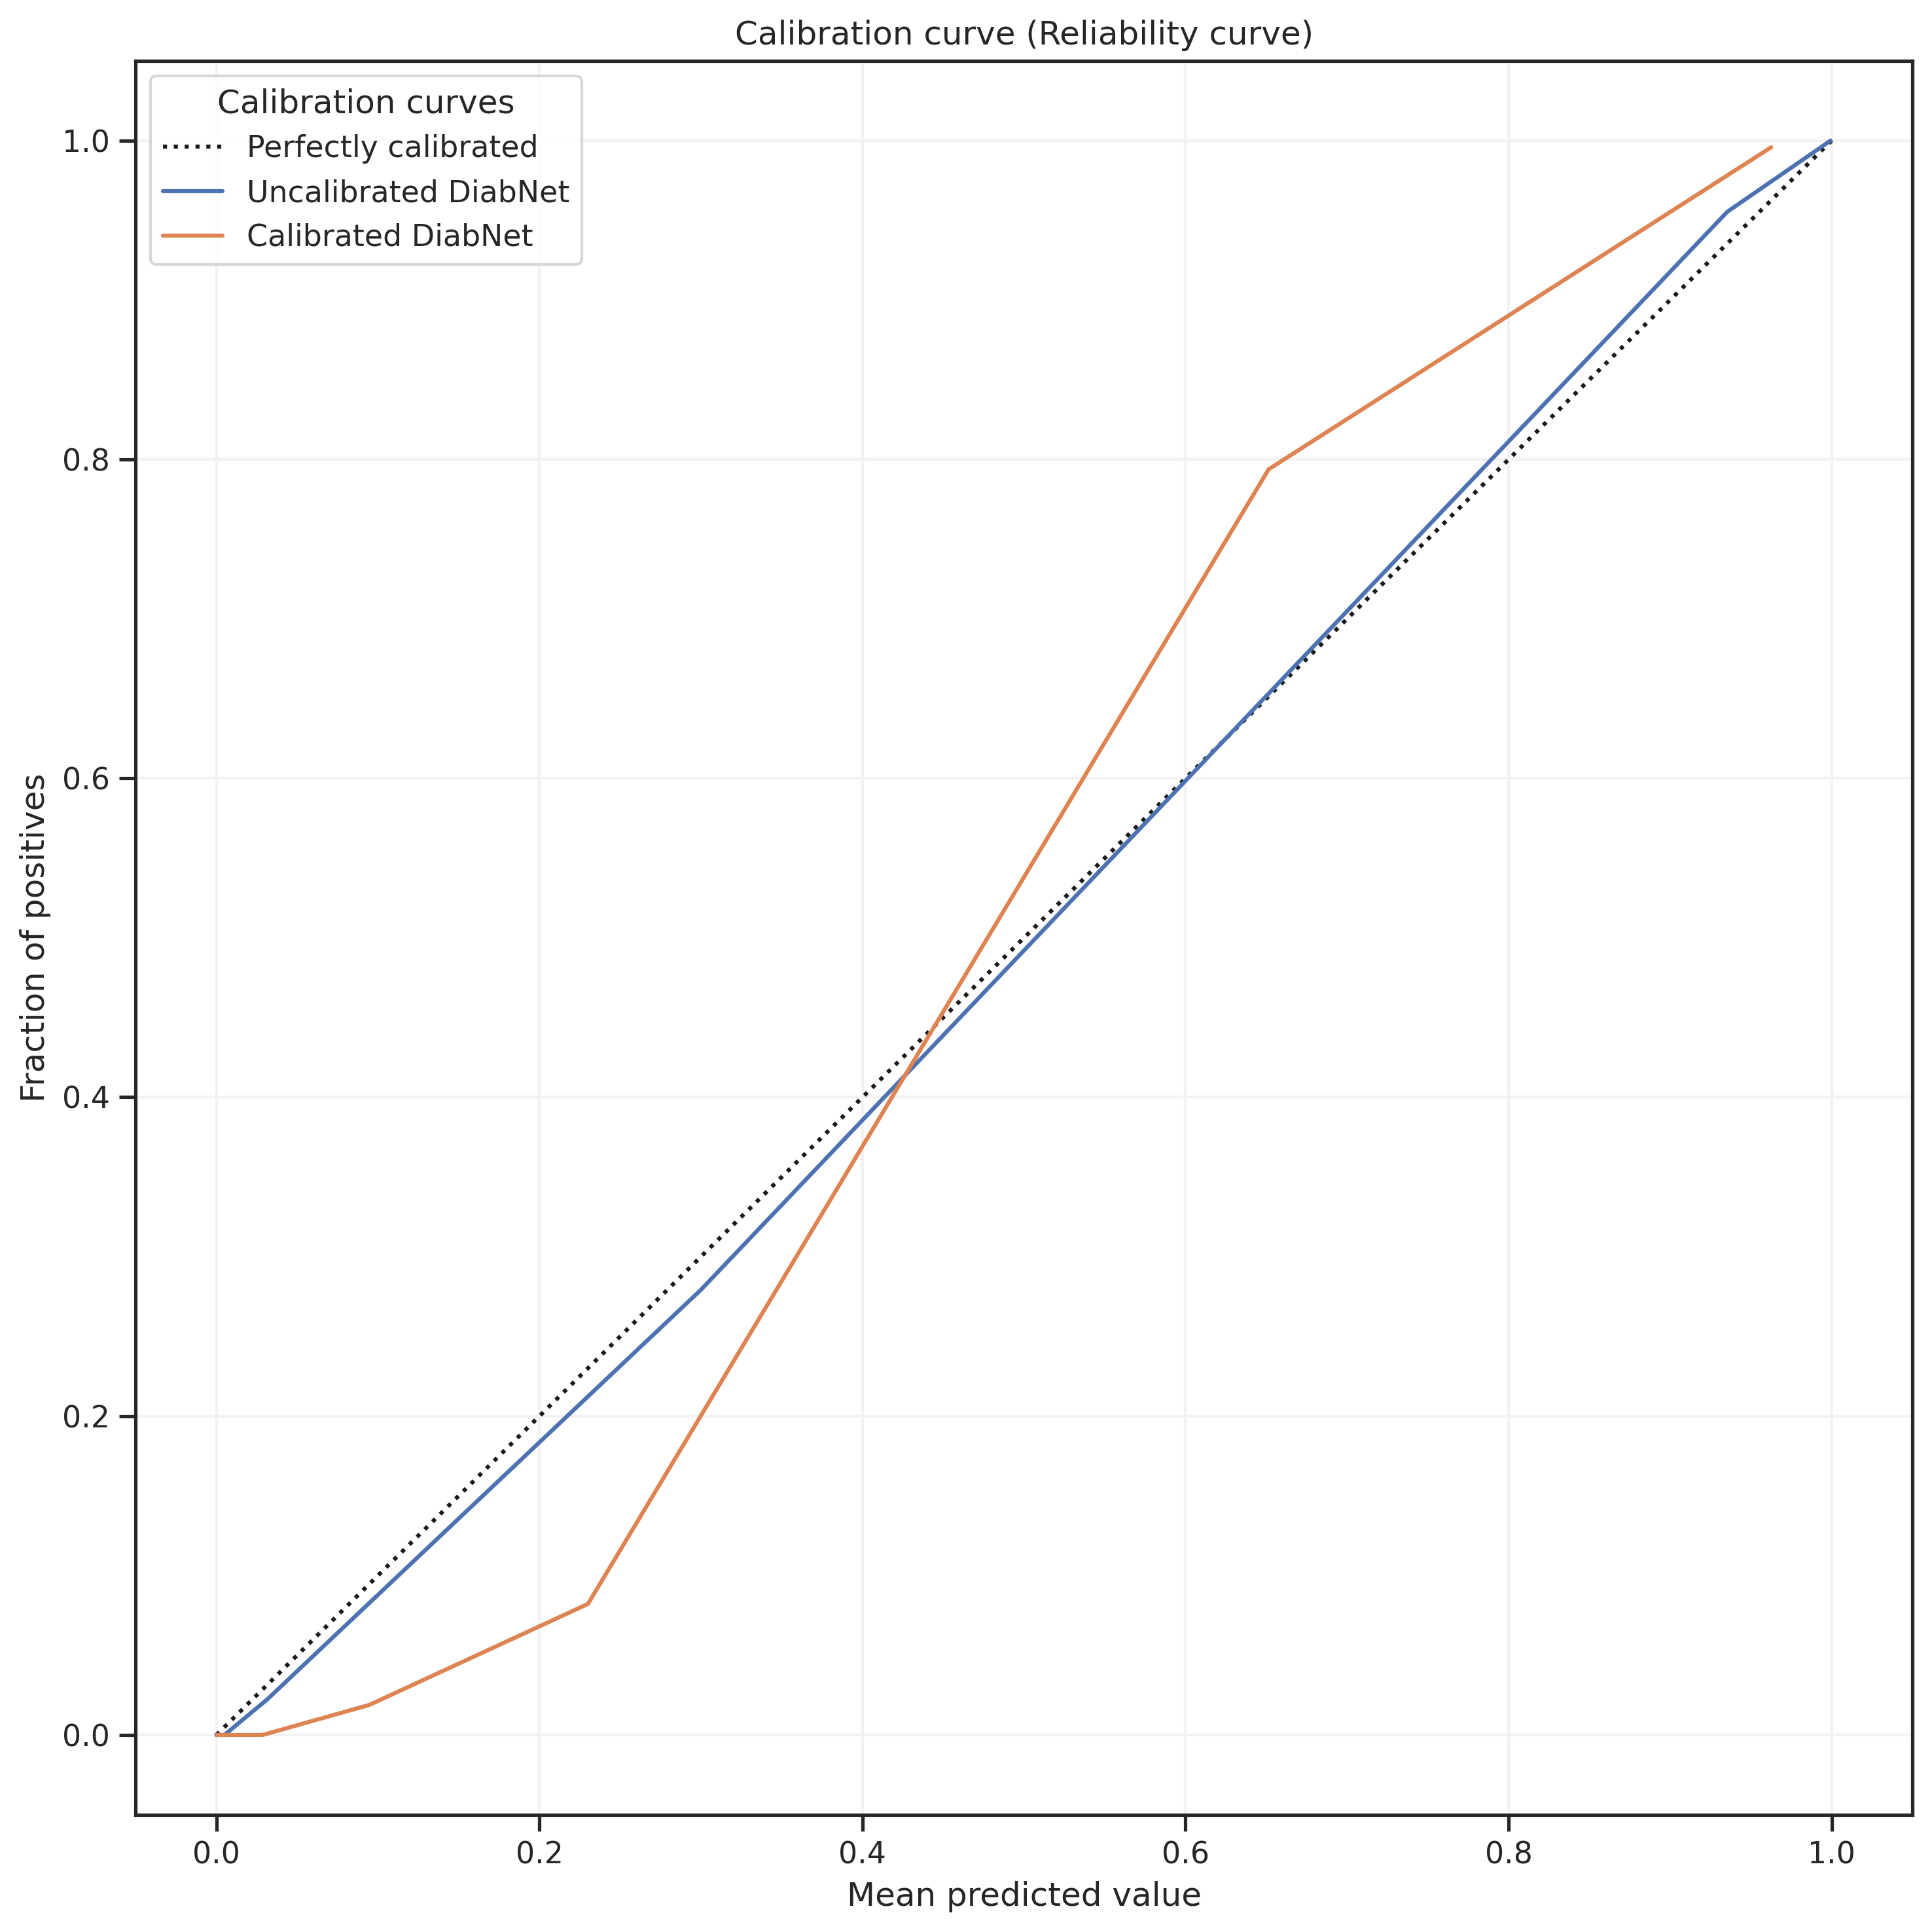

In [31]:
# Create figure
plt.figure(figsize=(10, 10), dpi=300)

# Create subplot
ax = plt.subplot(111)

# Plot perfectly calibrated curve
ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

# -- Uncalibrated Predictions -- #

# Plot calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(
    training['Labels'], 
    training['Predictions'], 
    n_bins=10, 
    strategy='quantile'
)

# Plot DiabNet curve
ax.plot(mean_predicted_value, fraction_of_positives, label="Uncalibrated DiabNet")

# -- Calibrated Predictions -- #

# Plot calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(
    training['Labels'], 
    training['Calibrated Predictions'], 
    n_bins=10, 
    strategy='quantile'
)

# Plot DiabNet curve
ax.plot(mean_predicted_value, fraction_of_positives, label="Calibrated DiabNet")


# Configuring plot
ax.set_title('Calibration curve (Reliability curve)')
ax.set_ylabel('Fraction of positives')
ax.set_xlabel('Mean predicted value')

# Configure legend
ax.legend(
    title='Calibration curves',
    loc="upper left",
)

# Display plot
plt.tight_layout()
plt.show()

# Save figure to file
if SAVE:
    if not os.path.exists("./images"):
        os.makedirs("./images")
    plt.savefig("./images/notebook3-plot7.svg", dpi=300)

## Performance analysis on 300 samples of test dataset using Platt-binning calibrator

In [32]:
# Loading ensemble
ensemble = Ensemble('../results/models/positive/model-positive-21-adamw-lc7-2021-10-05')

# Create DiabNet Report
report = DiabNetReport(ensemble, "positivo_1000_random_0.csv")

NEGATIVE FILE ../data/datasets/visits_sp_unique_test_positivo_1000_random_0_negatives_older60.csv


<ipython-input-33-ec30d2ba68f7>:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


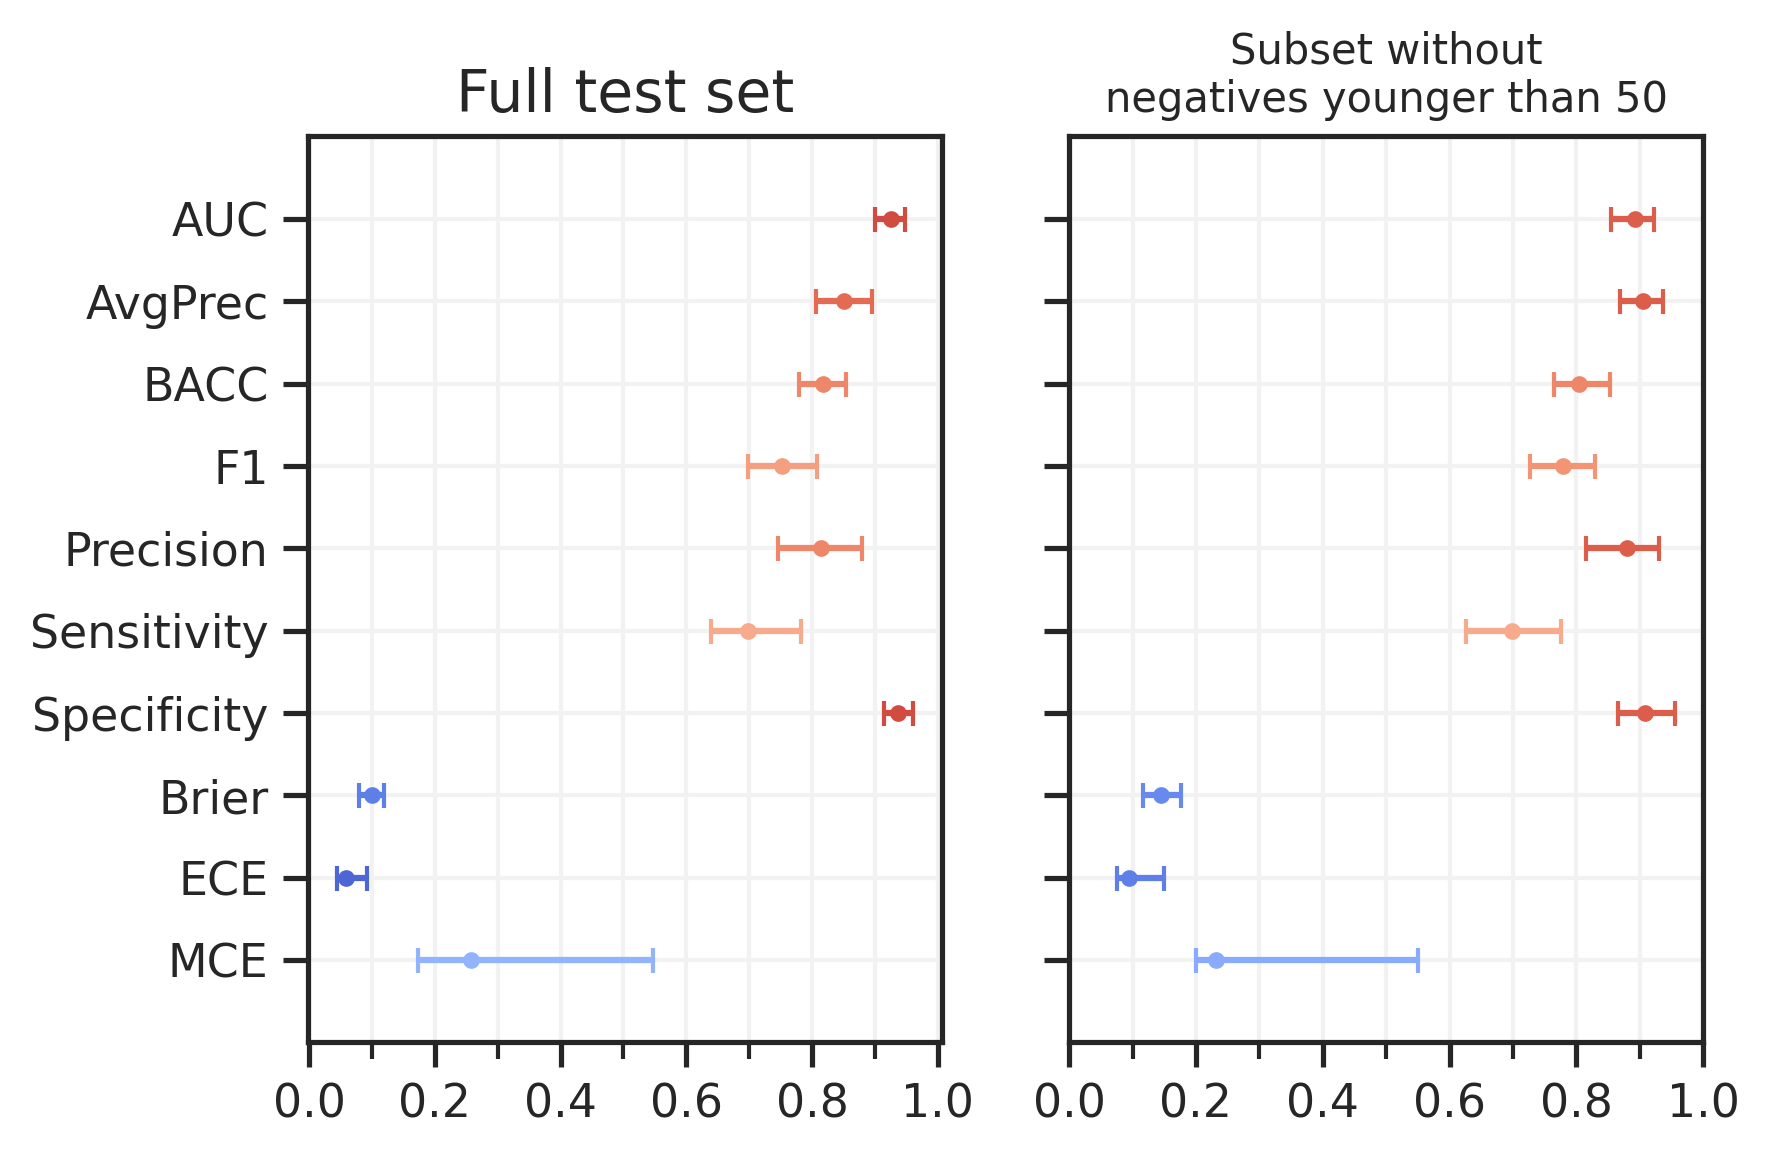

In [33]:
# Full test metrics
from diabnet.analysis.analysis import plot_metrics
fig = plot_metrics(report, interval="HDI")
fig.show()

In [34]:
# Training the Platt-binning calibrator

# Use Platt binning to train a recalibrator.
calibrator = calibration.PlattBinnerCalibrator(250, num_bins=10)
calibrator.train_calibration(
    report._dataset_test_unique._predictions[0:250], 
    report._dataset_test_unique._labels[0:250]
)

In [35]:
# Calculate metrics
from collections import OrderedDict
from matplotlib.ticker import AutoMinorLocator

# Calculate metrics for uncalibrated predictions
metrics = OrderedDict(
    {
        "AUC": [report._auc(report._dataset_test_unique, interval='HDI', bootnum=1000, alpha=0.05), None, None],
        "AvgPrec": [report._average_precision(report._dataset_test_unique, interval='HDI', bootnum=1000, alpha=0.05), None, None],
        "BACC": [report._bacc(report._dataset_test_unique, interval='HDI', bootnum=1000, alpha=0.05), None, None],
        "F1": [report._f1(report._dataset_test_unique, interval='HDI', bootnum=1000, alpha=0.05), None, None],
        "Precision": [report._precision(report._dataset_test_unique, interval='HDI', bootnum=1000, alpha=0.05), None, None],
        "Sensitivity": [report._recall(report._dataset_test_unique, interval='HDI', bootnum=1000, pos_label=0, alpha=0.05), None, None],
        "Specificity": [report._recall(report._dataset_test_unique, interval='HDI', bootnum=1000, pos_label=1, alpha=0.05), None, None],
        "Brier": [report._brier(report._dataset_test_unique, interval='HDI', bootnum=1000, alpha=0.05), None, None],
        "ECE": [report._ece(report._dataset_test_unique, interval='HDI', bootnum=1000, alpha=0.05), None, None],
        "MCE": [report._mce(report._dataset_test_unique, interval='HDI', bootnum=1000, alpha=0.05), None, None],
    }
)

# Keep last 300 samples
report._dataset_test_unique._labels = report._dataset_test_unique._labels[250:]
report._dataset_test_unique._features = report._dataset_test_unique._features[250:]
report._dataset_test_unique._predictions = report._dataset_test_unique._predictions[250:]
report._dataset_test_unique._predictions_ensemble = report._dataset_test_unique._predictions_ensemble[250:,]

# Calculate metrics for uncalibrated predictions (last 300 samples)
metrics["AUC"][1] = report._auc(report._dataset_test_unique, interval='HDI', bootnum=1000, alpha=0.05)
metrics["AvgPrec"][1] = report._average_precision(report._dataset_test_unique, interval='HDI', bootnum=1000, alpha=0.05)
metrics["BACC"][1] = report._bacc(report._dataset_test_unique, interval='HDI', bootnum=1000, alpha=0.05)
metrics["F1"][1] = report._f1(report._dataset_test_unique, interval='HDI', bootnum=1000, alpha=0.05)
metrics["Precision"][1] = report._precision(report._dataset_test_unique, interval='HDI', bootnum=1000, alpha=0.05)
metrics["Sensitivity"][1] = report._recall(report._dataset_test_unique, interval='HDI', bootnum=1000, alpha=0.05, pos_label=0)
metrics["Specificity"][1] = report._recall(report._dataset_test_unique, interval='HDI', bootnum=1000, alpha=0.05, pos_label=1)
metrics["Brier"][1] = report._brier(report._dataset_test_unique, interval='HDI', bootnum=1000, alpha=0.05)
metrics["ECE"][1] = report._ece(report._dataset_test_unique, interval='HDI', bootnum=1000, alpha=0.05)
metrics["MCE"][1] = report._mce(report._dataset_test_unique, interval='HDI', bootnum=1000, alpha=0.05)

# Calibrate mean predictions
report._dataset_test_unique._predictions = calibrator.calibrate(
    report._dataset_test_unique._predictions
)

# Calibrate ensemble predictions
for i in range(len(report._dataset_test_unique._predictions_ensemble)):
    report._dataset_test_unique._predictions_ensemble[i] = calibrator.calibrate(
        report._dataset_test_unique._predictions_ensemble[i]
    )
    
# Calculate metrics for calibrated predictions
metrics["AUC"][2] = report._auc(report._dataset_test_unique, interval='HDI', bootnum=1000, alpha=0.05)
metrics["AvgPrec"][2] = report._average_precision(report._dataset_test_unique, interval='HDI', bootnum=1000, alpha=0.05)
metrics["BACC"][2] = report._bacc(report._dataset_test_unique, interval='HDI', bootnum=1000, alpha=0.05)
metrics["F1"][2] = report._f1(report._dataset_test_unique, interval='HDI', bootnum=1000, alpha=0.05)
metrics["Precision"][2] = report._precision(report._dataset_test_unique, interval='HDI', bootnum=1000, alpha=0.05)
metrics["Sensitivity"][2] = report._recall(report._dataset_test_unique, interval='HDI', bootnum=1000, alpha=0.05, pos_label=0)
metrics["Specificity"][2] = report._recall(report._dataset_test_unique, interval='HDI', bootnum=1000, alpha=0.05, pos_label=1)
metrics["Brier"][2] = report._brier(report._dataset_test_unique, interval='HDI', bootnum=1000, alpha=0.05)
metrics["ECE"][2] = report._ece(report._dataset_test_unique, interval='HDI', bootnum=1000, alpha=0.05)
metrics["MCE"][2] = report._mce(report._dataset_test_unique, interval='HDI', bootnum=1000, alpha=0.05)

### Plot 8: Metrics of complete test set (uncalibrated predictions) and partial test set (uncalibrated and calibrated predictions)

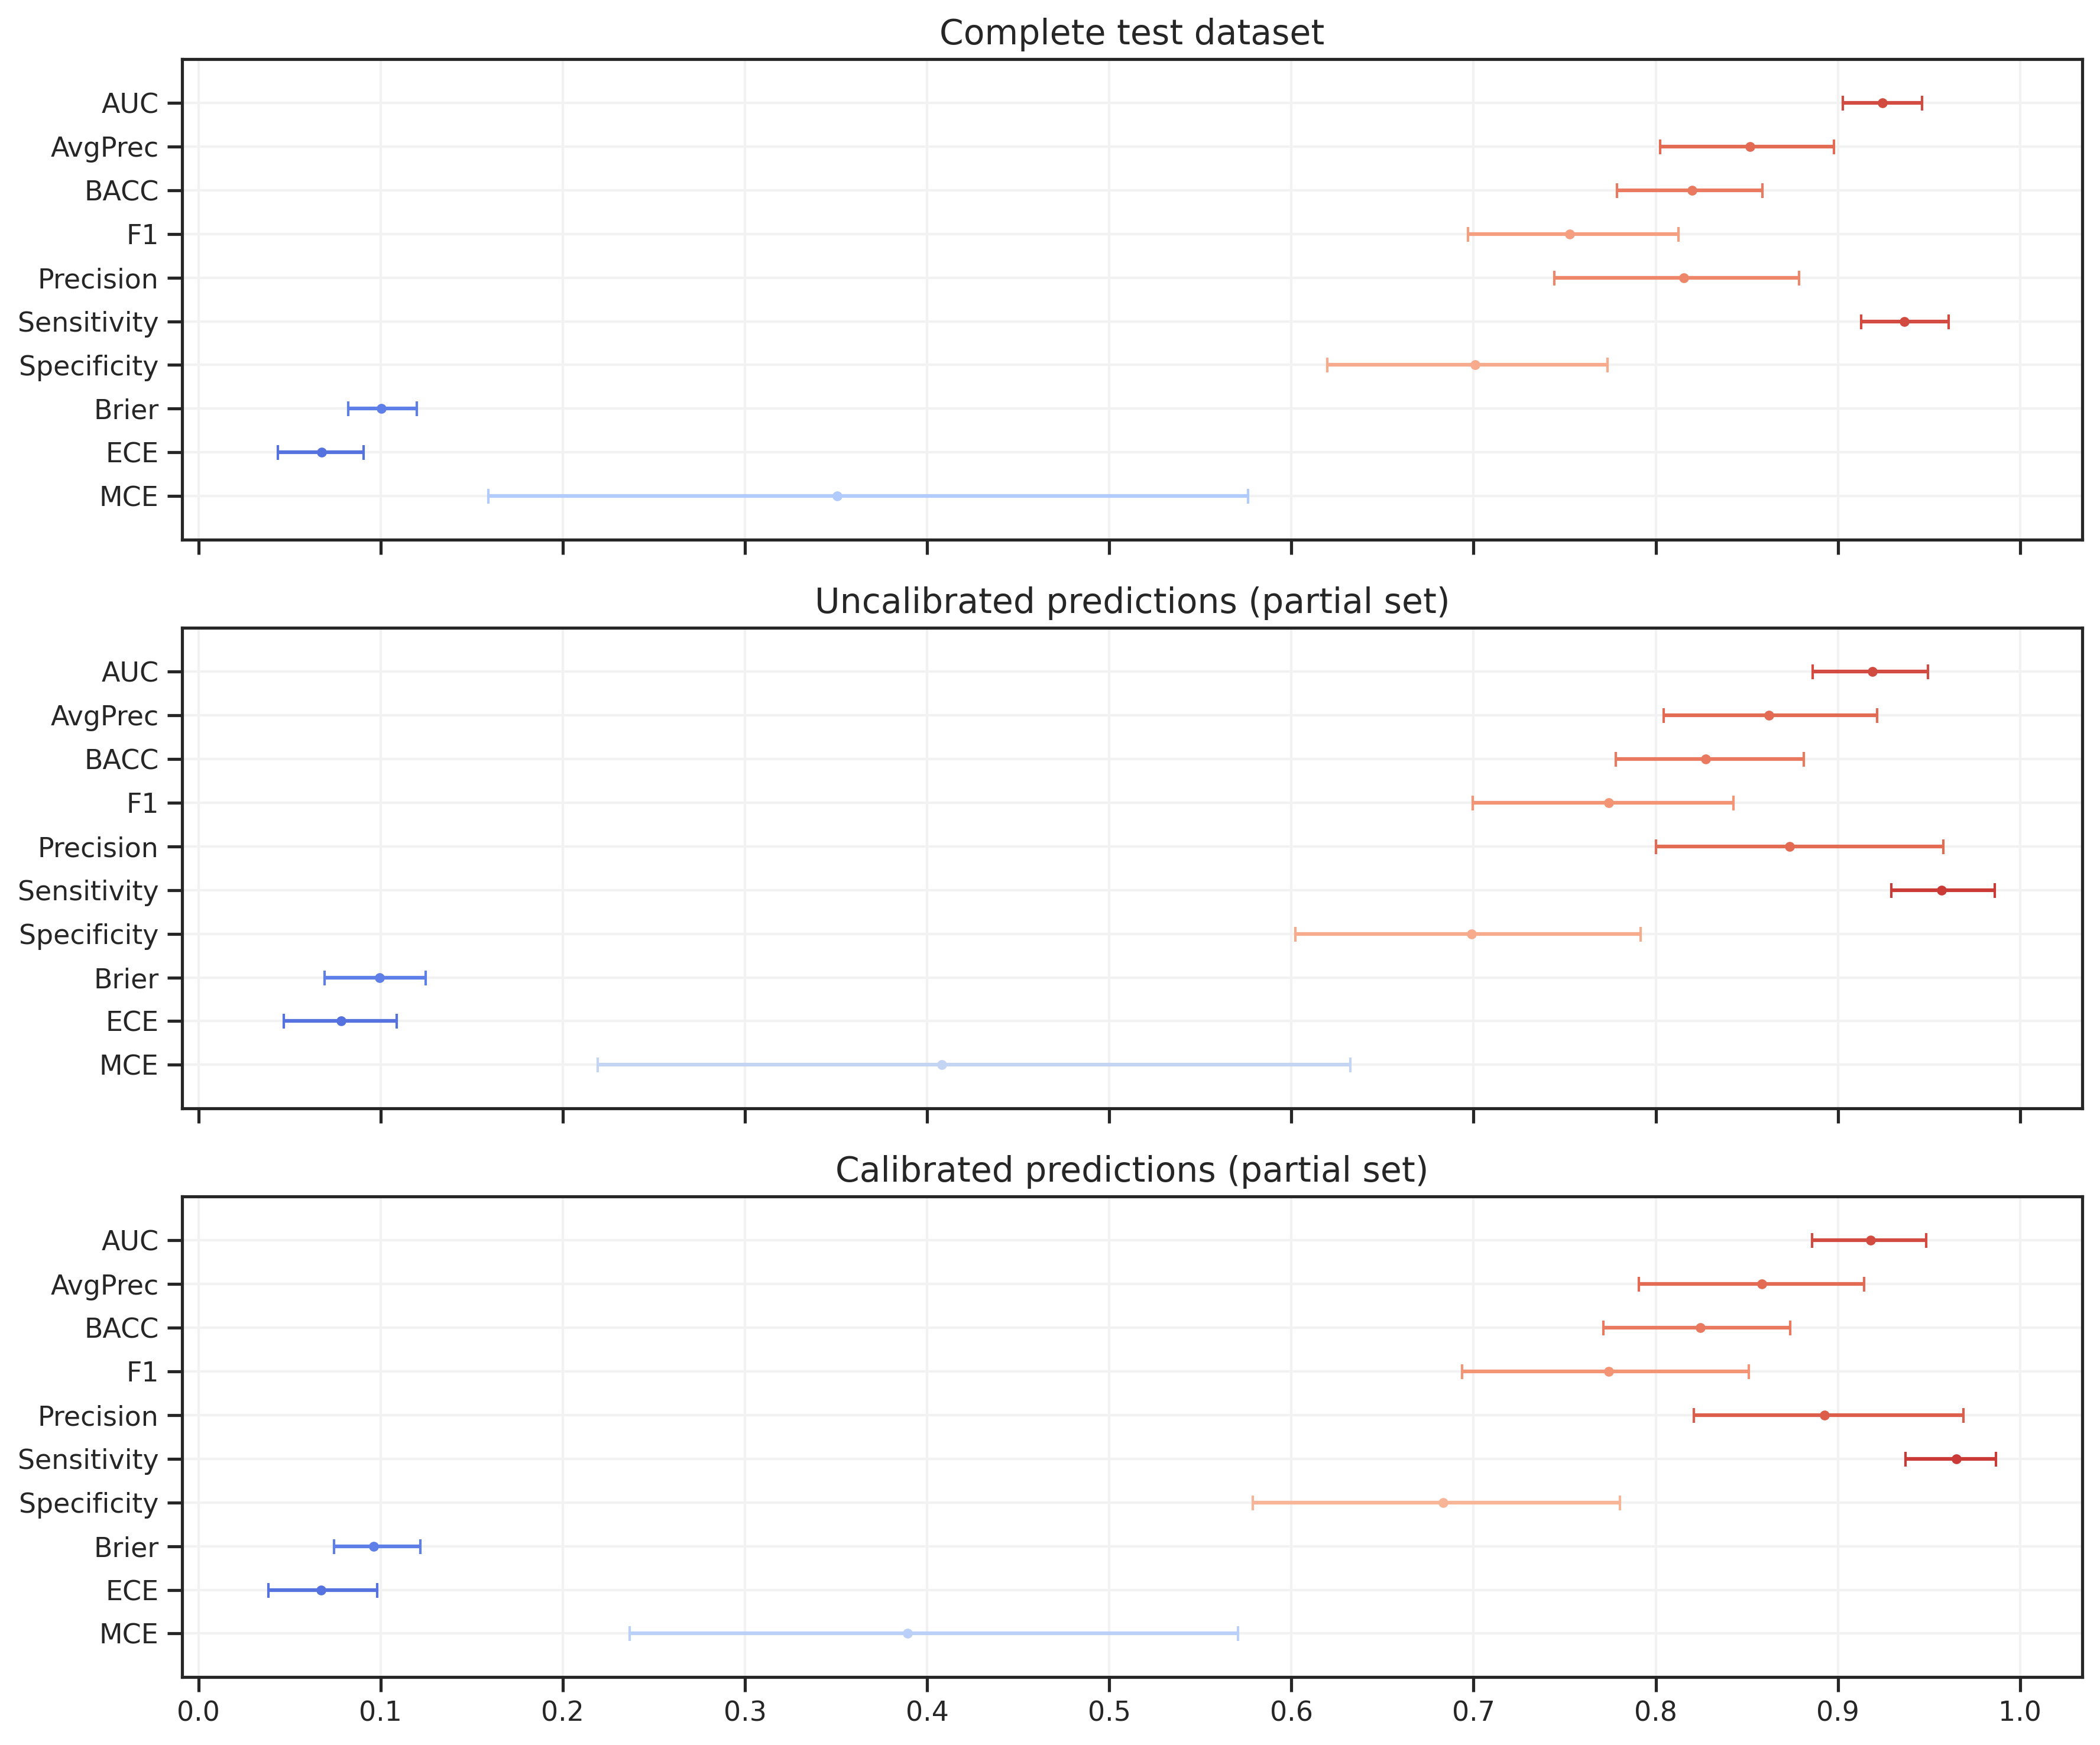

In [36]:
# Create subplot
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(12, 10), nrows=3, sharex=True, dpi=300)

# Color palette
palette = sns.color_palette("coolwarm", n_colors=33)

for (i, k) in enumerate(metrics.keys()):
    ax0.errorbar(
        metrics[k][0]["mean"],
        i,
        xerr=[[metrics[k][0]["mean"] - metrics[k][0]["lower"]], [metrics[k][0]["upper"] - metrics[k][0]["mean"]]],
        fmt=".",
        capsize=3.0,
        color=palette[int(metrics[k][0]["mean"] * 33)],
    )
    ax1.errorbar(
        metrics[k][1]["mean"],
        i,
        xerr=[[metrics[k][1]["mean"] - metrics[k][1]["lower"]], [metrics[k][1]["upper"] - metrics[k][1]["mean"]]],
        fmt=".",
        capsize=3.0,
        color=palette[int(metrics[k][1]["mean"] * 33)],
    )
    ax2.errorbar(
        metrics[k][2]["mean"],
        i,
        xerr=[[metrics[k][2]["mean"] - metrics[k][2]["lower"]], [metrics[k][2]["upper"] - metrics[k][2]["mean"]]],
        fmt=".",
        capsize=3.0,
        color=palette[int(metrics[k][2]["mean"] * 33)],
    )
    
    
# Configure subplot 1
ax0.set_title("Complete test dataset", fontsize=14)
ax0.set_xticks(np.arange(0, 1.01, 0.1))
ax0.xaxis.grid(True, which="minor")
ax0.set_ylim(len(metrics), -1)
ax0.set_yticks(range(len(metrics)))
ax0.set_yticklabels(metrics.keys())

# Configure subplot 2
ax1.set_title("Uncalibrated predictions (partial set)", fontsize=14)
ax1.set_ylim(len(metrics), -1)
ax1.set_yticks(range(len(metrics)))
ax1.set_yticklabels(metrics.keys())

# Configure subplot 3
ax2.set_title("Calibrated predictions (partial set)", fontsize=14)
ax2.set_ylim(len(metrics), -1)
ax2.set_yticks(range(len(metrics)))
ax2.set_yticklabels(metrics.keys())

# Display plot
plt.tight_layout()
plt.show()

# Save figure to file
if SAVE:
    if not os.path.exists("./images"):
        os.makedirs("./images")
    plt.savefig("./images/notebook3-plot8.svg", dpi=300)